# 5. Classification

# 5.1 Import Libraries

In [0]:
from pyspark.sql.functions import lit, col, desc, to_date, length, count, when, hour, dayofweek, round, explode, lower, udf, mean, stddev, min, max, coalesce, row_number, monotonically_increasing_id, floor, round as spark_round
from pyspark.sql.types import ArrayType, StringType, FloatType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, BucketedRandomProjectionLSH
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.impute import KNNImputer
from functools import reduce

import re

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, PCA
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [0]:
# Initialize Spark session
spark = SparkSession.builder.appName("Classification").getOrCreate()

# 5.2 Import Dfs

In [0]:
# Import train, val and test
train_df = spark.read.format("delta").load("/dbfs/FileStore/tables/train_df")
val_df = spark.read.format("delta").load("/dbfs/FileStore/tables/val_df")
test_df = spark.read.format("delta").load("/dbfs/FileStore/tables/test_df")

# Display train_df
train_df.limit(10).display()

ROUTE DESTINATION_AIRPORT ORIGIN_AIRPORT AIRLINE FLIGHT_NUMBER index YEAR MONTH DAY DAY_OF_WEEK DEPARTURE_DELAY TAXI_OUT SCHEDULED_TIME DISTANCE ARRIVAL_DELAY AIR_SYSTEM_DELAY SECURITY_DELAY AIRLINE_DELAY LATE_AIRCRAFT_DELAY WEATHER_DELAY SEASON SCHEDULED_DEPARTURE_PERIOD IS_WEEKEND DELAYED_DEPARTURE_FLAG TOTAL_KNOWN_DELAY SCHEDULED_DEPARTURE_min SCHEDULED_ARRIVAL_min DEPARTURE_TIME_min WHEELS_OFF_min ARRIVAL_TIME_min SEASON_vec SCHEDULED_DEPARTURE_PERIOD_vec FLIGHT_NUMBER_freq TAIL_NUMBER_freq AIRLINE_freq ORIGIN_AIRPORT_freq DESTINATION_AIRPORT_freq ROUTE_freq BIS_MSP MSP BIS OO 4519 243 2015 3 1 7 42 12 81 386.0 37 0 0 0 37 0 Spring Afternoon 1 1 37 908 989 950 962 1026 Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0)) 2.14E-4 2.4E-4 0.10407 5.07E-4 0.017857 2.67E-4 ATL_IND IND ATL DL 2366 523 2015 5 1 5 41 14 93 432.0 33 0 0 33 0 0 Spring Night 0 1 33 1265 1358 1306 1320 1391 Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(5), values -> List(1.0)) 1.87E-4 2.4E-4 0.109462 0.054451 0.005392 6.94E-4 LGA_BOS BOS LGA US 2122 650 2015 6 1 1 87 34 74 184.0 94 7 0 24 63 0 Summer Evening 0 1 94 1140 1214 1227 1261 1308 Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) 1.87E-4 4.0E-4 0.03179 0.022021 0.02114 0.001388 CLT_ATL ATL CLT DL 1591 735 2015 7 1 3 217 17 79 226.0 208 0 0 208 0 0 Summer Morning 0 1 208 495 574 712 729 782 Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(2), values -> List(1.0)) 2.67E-4 3.2E-4 0.109462 0.020766 0.052129 0.001495 GRK_IAH IAH GRK EV 5803 770 2015 7 1 3 166 12 59 166.0 174 8 0 0 0 166 Summer Midday 0 1 174 774 833 940 952 1007 Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0)) 5.3E-5 3.47E-4 0.100921 6.94E-4 0.026985 8.0E-5 LAX_SAT SAT LAX WN 1959 804 2015 7 1 3 7 23 170 1211.0 24 17 0 7 0 0 Summer Early Morning 0 0 24 450 740 457 480 764 Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(4), values -> List(1.0)) 1.07E-4 4.0E-4 0.224236 0.040037 0.006833 3.74E-4 PBI_LGA LGA PBI DL 1238 1097 2015 10 1 4 50 13 178 1035.0 35 27 0 0 8 0 Autumn Evening 0 1 35 1100 1278 1150 1163 1313 Map(vectorType -> sparse, length -> 4, indices -> List(3), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) 3.2E-4 3.74E-4 0.109462 0.004618 0.025117 8.54E-4 CLT_PHX PHX CLT AA 463 1146 2015 11 1 7 15 27 266 1773.0 15 0 0 6 9 0 Autumn Evening 1 0 15 1195 1341 1210 1237 1356 Map(vectorType -> sparse, length -> 4, indices -> List(3), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) 3.2E-4 2.67E-4 0.122488 0.020766 0.023702 5.61E-4 BOS_SFO SFO BOS B6 833 1295 2015 1 2 5 2 16 406 2419.0 17 15 0 2 0 0 Winter Evening 0 0 17 1200 1426 1202 1218 3 Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) 3.2E-4 3.2E-4 0.055412 0.020259 0.032964 7.47E-4 IAH_TPA TPA IAH UA 1238 1367 2015 1 2 5 25 16 125 787.0 18 0 0 0 18 0 Winter Afternoon 0 1 18 937 1122 962 978 1140 Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0)) 3.2E-4 2.67E-4 0.097264 0.031122 0.011744 5.34E-4

In [0]:
# File location and type
clust_map_train_df_file_loc = "/FileStore/tables/mapping_train_df.csv"
clust_map_val_df_file_loc = "/FileStore/tables/mapping_val_df.csv"
clust_map_test_df_file_loc = "/FileStore/tables/mapping_test_df.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
clust_map_train_df = (
    spark.read.format(file_type)
    .option("inferSchema", infer_schema)
    .option("header", first_row_is_header)
    .option("sep", delimiter)
    .option("quote", '"') # To handle commas correctly
    .option("escape", '"')
    .option("multiLine", "true")  # Allow fields to span multiple lines (helps with complex quoted fields)
    .option("mode", "PERMISSIVE") # Avoid failing on corrupt records
    .load(clust_map_train_df_file_loc)
)

clust_map_val_df = (
    spark.read.format(file_type)
    .option("inferSchema", infer_schema)
    .option("header", first_row_is_header)
    .option("sep", delimiter)
    .option("quote", '"') # To handle commas correctly
    .option("escape", '"')
    .option("multiLine", "true")  # Allow fields to span multiple lines (helps with complex quoted fields)
    .option("mode", "PERMISSIVE") # Avoid failing on corrupt records
    .load(clust_map_val_df_file_loc)
)

clust_map_test_df = (
    spark.read.format(file_type)
    .option("inferSchema", infer_schema)
    .option("header", first_row_is_header)
    .option("sep", delimiter)
    .option("quote", '"') # To handle commas correctly
    .option("escape", '"')
    .option("multiLine", "true")  # Allow fields to span multiple lines (helps with complex quoted fields)
    .option("mode", "PERMISSIVE") # Avoid failing on corrupt records
    .load(clust_map_test_df_file_loc)
)

# Display result
clust_map_train_df.limit(10).display()

index cluster 1 4 2 3 3 4 4 4 5 2 6 4 7 2 8 1 9 1 10 1

In [0]:
train_df.printSchema()

root
 |-- ROUTE: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- index: integer (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- ARRIVAL_DELAY: integer (nullable = true)
 |-- AIR_SYSTEM_DELAY: integer (nullable = true)
 |-- SECURITY_DELAY: integer (nullable = true)
 |-- AIRLINE_DELAY: integer (nullable = true)
 |-- LATE_AIRCRAFT_DELAY: integer (nullable = true)
 |-- WEATHER_DELAY: integer (nullable = true)
 |-- SEASON: string (nullable = true)
 |-- SCHEDULED_DEPARTURE_PERIOD: string (nullable = true)
 |-- IS_WEEKEND: integer 

# 5.3 Create Classification Target

In [0]:
# List of delay columns
delay_cols = [
    "AIR_SYSTEM_DELAY",
    "SECURITY_DELAY",
    "AIRLINE_DELAY",
    "LATE_AIRCRAFT_DELAY",
    "WEATHER_DELAY"
]

In [0]:
from pyspark.sql.functions import col

# Create a condition to identifiy if all delay columns are equal to 0
all_zero_condition = reduce(lambda a, b: a & b, [(col(c) == 0) for c in delay_cols])

# Filter rows where all delay columns are 0
all_zero_delays_df = train_df.filter(all_zero_condition)

# Count them
zero_delay_count = all_zero_delays_df.count()

# Show count and display rows
print(f"Number of rows where all delay causes are zero: {zero_delay_count}")
all_zero_delays_df.select(delay_cols).limit(10).display()

Number of rows where all delay causes are zero: 0


AIR_SYSTEM_DELAY SECURITY_DELAY AIRLINE_DELAY LATE_AIRCRAFT_DELAY WEATHER_DELAY

In [0]:
from pyspark.sql.functions import greatest, col, when
from functools import reduce

# Compute max delay
max_delay = greatest(*[col(c) for c in delay_cols])

# Create 1/0 indicator columns for each delay column if it's equal to max delay
indicator_cols = [(col(c) == max_delay).cast("int") for c in delay_cols]

# Sum how many match the max (potential ties)
tie_count_col = reduce(lambda a, b: a + b, indicator_cols)

# Add tie count column
cleaned_train_df_with_ties = train_df.withColumn("tie_count", tie_count_col)

# Filter and count rows with ties (more than one delay equals the max)
tie_rows_df = cleaned_train_df_with_ties.filter(col("tie_count") > 1)
tie_count = tie_rows_df.count()

print(f"Number of rows with ties in delay causes: {tie_count}")

# Show tie rows
tie_rows_df.select(delay_cols + ["tie_count"]).limit(10).display()

Number of rows with ties in delay causes: 276


AIR_SYSTEM_DELAY SECURITY_DELAY AIRLINE_DELAY LATE_AIRCRAFT_DELAY WEATHER_DELAY tie_count 10 0 10 0 0 2 30 0 0 30 0 2 3 0 8 8 0 2 2 0 7 7 0 2 12 0 0 12 0 2 15 0 0 15 0 2 6 0 4 6 0 2 1 0 12 12 0 2 0 0 14 14 0 2 0 0 8 8 0 2

In [0]:
from pyspark.sql.functions import when, col, greatest
from functools import reduce

# Define priority mapping
priority_order = [
    ("AIR_SYSTEM_DELAY", "AIR_SYSTEM"), # Delays caused by air traffic control or system-wide problems. Usually critical.
    ("SECURITY_DELAY", "SECURITY"), # Delays related to security checks or incidents. Also very important.
    ("AIRLINE_DELAY", "AIRLINE"), # Delays caused by airline operations, like crew or maintenance.
    ("LATE_AIRCRAFT_DELAY", "LATE_AIRCRAFT"), # Delay caused by the late arrival of the aircraft from a previous flight.
    ("WEATHER_DELAY", "WEATHER") # Weather-related delays, generally unpredictable and outside control.
]

max_delay = greatest(*[col(c) for c in delay_cols])
total_delay = reduce(lambda a, b: a + b, [col(c) for c in delay_cols])

# Assign function
def add_target(df):
    df = df.withColumn("MAX_DELAY", max_delay)
    df = df.withColumn("TOTAL_DELAY", total_delay)
    
    expr = None
    for delay_col, label in priority_order:
        condition = (col(delay_col) == col("MAX_DELAY"))
        expr = when(condition, label) if expr is None else expr.when(condition, label)
    
    expr = when(col("TOTAL_DELAY") == 0, "NO_DELAY").otherwise(expr)
    df = df.withColumn("PRIMARY_DELAY_CAUSE", expr)
    
    return df.drop("MAX_DELAY", "TOTAL_DELAY")

# Apply
cleaned_train_df = add_target(train_df)
cleaned_val_df = add_target(val_df)
cleaned_test_df = add_target(test_df)

In [0]:
from pyspark.ml.feature import StringIndexer

# Create indexer and fit on train
target_indexer = StringIndexer(inputCol="PRIMARY_DELAY_CAUSE", outputCol="PRIMARY_DELAY_CAUSE_index")
target_indexer_model = target_indexer.fit(cleaned_train_df)

# Transform all datasets using the same fitted model
cleaned_train_df = target_indexer_model.transform(cleaned_train_df)
cleaned_val_df = target_indexer_model.transform(cleaned_val_df)
cleaned_test_df = target_indexer_model.transform(cleaned_test_df)

In [0]:
cleaned_train_df.limit(10).display()

ROUTE DESTINATION_AIRPORT ORIGIN_AIRPORT AIRLINE FLIGHT_NUMBER index YEAR MONTH DAY DAY_OF_WEEK DEPARTURE_DELAY TAXI_OUT SCHEDULED_TIME DISTANCE ARRIVAL_DELAY AIR_SYSTEM_DELAY SECURITY_DELAY AIRLINE_DELAY LATE_AIRCRAFT_DELAY WEATHER_DELAY SEASON SCHEDULED_DEPARTURE_PERIOD IS_WEEKEND DELAYED_DEPARTURE_FLAG TOTAL_KNOWN_DELAY SCHEDULED_DEPARTURE_min SCHEDULED_ARRIVAL_min DEPARTURE_TIME_min WHEELS_OFF_min ARRIVAL_TIME_min SEASON_vec SCHEDULED_DEPARTURE_PERIOD_vec FLIGHT_NUMBER_freq TAIL_NUMBER_freq AIRLINE_freq ORIGIN_AIRPORT_freq DESTINATION_AIRPORT_freq ROUTE_freq PRIMARY_DELAY_CAUSE PRIMARY_DELAY_CAUSE_index BIS_MSP MSP BIS OO 4519 243 2015 3 1 7 42 12 81 386.0 37 0 0 0 37 0 Spring Afternoon 1 1 37 908 989 950 962 1026 Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0)) 2.14E-4 2.4E-4 0.10407 5.07E-4 0.017857 2.67E-4 LATE_AIRCRAFT 0.0 ATL_IND IND ATL DL 2366 523 2015 5 1 5 41 14 93 432.0 33 0 0 33 0 0 Spring Night 0 1 33 1265 1358 1306 1320 1391 Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(5), values -> List(1.0)) 1.87E-4 2.4E-4 0.109462 0.054451 0.005392 6.94E-4 AIRLINE 1.0 LGA_BOS BOS LGA US 2122 650 2015 6 1 1 87 34 74 184.0 94 7 0 24 63 0 Summer Evening 0 1 94 1140 1214 1227 1261 1308 Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) 1.87E-4 4.0E-4 0.03179 0.022021 0.02114 0.001388 LATE_AIRCRAFT 0.0 CLT_ATL ATL CLT DL 1591 735 2015 7 1 3 217 17 79 226.0 208 0 0 208 0 0 Summer Morning 0 1 208 495 574 712 729 782 Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(2), values -> List(1.0)) 2.67E-4 3.2E-4 0.109462 0.020766 0.052129 0.001495 AIRLINE 1.0 GRK_IAH IAH GRK EV 5803 770 2015 7 1 3 166 12 59 166.0 174 8 0 0 0 166 Summer Midday 0 1 174 774 833 940 952 1007 Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0)) 5.3E-5 3.47E-4 0.100921 6.94E-4 0.026985 8.0E-5 WEATHER 3.0 LAX_SAT SAT LAX WN 1959 804 2015 7 1 3 7 23 170 1211.0 24 17 0 7 0 0 Summer Early Morning 0 0 24 450 740 457 480 764 Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(4), values -> List(1.0)) 1.07E-4 4.0E-4 0.224236 0.040037 0.006833 3.74E-4 AIR_SYSTEM 2.0 PBI_LGA LGA PBI DL 1238 1097 2015 10 1 4 50 13 178 1035.0 35 27 0 0 8 0 Autumn Evening 0 1 35 1100 1278 1150 1163 1313 Map(vectorType -> sparse, length -> 4, indices -> List(3), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) 3.2E-4 3.74E-4 0.109462 0.004618 0.025117 8.54E-4 AIR_SYSTEM 2.0 CLT_PHX PHX CLT AA 463 1146 2015 11 1 7 15 27 266 1773.0 15 0 0 6 9 0 Autumn Evening 1 0 15 1195 1341 1210 1237 1356 Map(vectorType -> sparse, length -> 4, indices -> List(3), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) 3.2E-4 2.67E-4 0.122488 0.020766 0.023702 5.61E-4 LATE_AIRCRAFT 0.0 BOS_SFO SFO BOS B6 833 1295 2015 1 2 5 2 16 406 2419.0 17 15 0 2 0 0 Winter Evening 0 0 17 1200 1426 1202 1218 3 Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) 3.2E-4 3.2E-4 0.055412 0.020259 0.032964 7.47E-4 AIR_SYSTEM 2.0 IAH_TPA TPA IAH UA 1238 1367 2015 1 2 5 25 16 125 787.0 18 0 0 0 18 0 Winter Afternoon 0 1 18 937 1122 962 978 1140 Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0)) 3.2E-4 2.67E-4 0.097264 0.031122 0.011744 5.34E-4 LAT

# 5.4 Imbalance

In [0]:
# Count occurrences of each class
class_distribution = cleaned_train_df.groupBy("PRIMARY_DELAY_CAUSE").count()

# Compute total count
total_count = cleaned_train_df.count()

# Add percentage column
class_distribution = class_distribution.withColumn(
    "percentage",
    round((col("count") / total_count) * 100, 2)
).orderBy("percentage", ascending=False)

# Display result
class_distribution.display()

PRIMARY_DELAY_CAUSE count percentage LATE_AIRCRAFT 14585 39.1 AIRLINE 10880 29.17 AIR_SYSTEM 10510 28.18 WEATHER 1252 3.36 SECURITY 71 0.19

**Conclusion:** The dataset is imbalanced, with the WEATHER and SECURITY classes significantly underrepresented compared to others.

In [0]:
from pyspark.sql.functions import col, lit
from pyspark.sql import Window
import pyspark.sql.functions as F

# Get total number of samples
total = cleaned_train_df.count()

# Calculate class frequencies
class_counts = cleaned_train_df.groupBy("PRIMARY_DELAY_CAUSE").count()

# Compute inverse frequency as weights
weights_df = class_counts.withColumn("weight", round(lit(total) / col("count"), 4))

# Join weights back to original DataFrame
cleaned_train_df = cleaned_train_df.join(weights_df.select("PRIMARY_DELAY_CAUSE", "weight"), on="PRIMARY_DELAY_CAUSE", how="left")

weights_df.display()
cleaned_train_df.limit(10).display()

PRIMARY_DELAY_CAUSE count weight WEATHER 1252 29.7907 AIR_SYSTEM 10510 3.5488 LATE_AIRCRAFT 14585 2.5573 AIRLINE 10880 3.4281 SECURITY 71 525.3239

PRIMARY_DELAY_CAUSE ROUTE DESTINATION_AIRPORT ORIGIN_AIRPORT AIRLINE FLIGHT_NUMBER index YEAR MONTH DAY DAY_OF_WEEK DEPARTURE_DELAY TAXI_OUT SCHEDULED_TIME DISTANCE ARRIVAL_DELAY AIR_SYSTEM_DELAY SECURITY_DELAY AIRLINE_DELAY LATE_AIRCRAFT_DELAY WEATHER_DELAY SEASON SCHEDULED_DEPARTURE_PERIOD IS_WEEKEND DELAYED_DEPARTURE_FLAG TOTAL_KNOWN_DELAY SCHEDULED_DEPARTURE_min SCHEDULED_ARRIVAL_min DEPARTURE_TIME_min WHEELS_OFF_min ARRIVAL_TIME_min SEASON_vec SCHEDULED_DEPARTURE_PERIOD_vec FLIGHT_NUMBER_freq TAIL_NUMBER_freq AIRLINE_freq ORIGIN_AIRPORT_freq DESTINATION_AIRPORT_freq ROUTE_freq PRIMARY_DELAY_CAUSE_index weight LATE_AIRCRAFT BIS_MSP MSP BIS OO 4519 243 2015 3 1 7 42 12 81 386.0 37 0 0 0 37 0 Spring Afternoon 1 1 37 908 989 950 962 1026 Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0)) 2.14E-4 2.4E-4 0.10407 5.07E-4 0.017857 2.67E-4 0.0 2.5573 AIRLINE ATL_IND IND ATL DL 2366 523 2015 5 1 5 41 14 93 432.0 33 0 0 33 0 0 Spring Night 0 1 33 1265 1358 1306 1320 1391 Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(5), values -> List(1.0)) 1.87E-4 2.4E-4 0.109462 0.054451 0.005392 6.94E-4 1.0 3.4281 LATE_AIRCRAFT LGA_BOS BOS LGA US 2122 650 2015 6 1 1 87 34 74 184.0 94 7 0 24 63 0 Summer Evening 0 1 94 1140 1214 1227 1261 1308 Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) 1.87E-4 4.0E-4 0.03179 0.022021 0.02114 0.001388 0.0 2.5573 AIRLINE CLT_ATL ATL CLT DL 1591 735 2015 7 1 3 217 17 79 226.0 208 0 0 208 0 0 Summer Morning 0 1 208 495 574 712 729 782 Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(2), values -> List(1.0)) 2.67E-4 3.2E-4 0.109462 0.020766 0.052129 0.001495 1.0 3.4281 WEATHER GRK_IAH IAH GRK EV 5803 770 2015 7 1 3 166 12 59 166.0 174 8 0 0 0 166 Summer Midday 0 1 174 774 833 940 952 1007 Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0)) 5.3E-5 3.47E-4 0.100921 6.94E-4 0.026985 8.0E-5 3.0 29.7907 AIR_SYSTEM LAX_SAT SAT LAX WN 1959 804 2015 7 1 3 7 23 170 1211.0 24 17 0 7 0 0 Summer Early Morning 0 0 24 450 740 457 480 764 Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(4), values -> List(1.0)) 1.07E-4 4.0E-4 0.224236 0.040037 0.006833 3.74E-4 2.0 3.5488 AIR_SYSTEM PBI_LGA LGA PBI DL 1238 1097 2015 10 1 4 50 13 178 1035.0 35 27 0 0 8 0 Autumn Evening 0 1 35 1100 1278 1150 1163 1313 Map(vectorType -> sparse, length -> 4, indices -> List(3), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) 3.2E-4 3.74E-4 0.109462 0.004618 0.025117 8.54E-4 2.0 3.5488 LATE_AIRCRAFT CLT_PHX PHX CLT AA 463 1146 2015 11 1 7 15 27 266 1773.0 15 0 0 6 9 0 Autumn Evening 1 0 15 1195 1341 1210 1237 1356 Map(vectorType -> sparse, length -> 4, indices -> List(3), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) 3.2E-4 2.67E-4 0.122488 0.020766 0.023702 5.61E-4 0.0 2.5573 AIR_SYSTEM BOS_SFO SFO BOS B6 833 1295 2015 1 2 5 2 16 406 2419.0 17 15 0 2 0 0 Winter Evening 0 0 17 1200 1426 1202 1218 3 Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) 3.2E-4 3.2E-4 0.055412 0.020259 0.032964 7.47E-4 2.0 3.5488 LATE_AIRCRAFT IAH_TPA TPA IAH UA 1238 1367 2015 1 2 5 25 16 125 787.0 18 0 0 0 18 0 Winter Afternoon 0 1 18 937 1122 962 978 1140 Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -

# 5.5 Drop Features

In [0]:
# List of columns to drop
cols_to_drop = [
    "YEAR",
    "MONTH",
    "DAY",
    "FLIGHT_NUMBER",
    "ARRIVAL_DELAY",
    "ARRIVAL_TIME",
    "TAXI_IN",
    "WHEELS_ON",
    "TOTAL_KNOWN_DELAY",
    "AIR_SYSTEM_DELAY",
    "SECURITY_DELAY",
    "AIRLINE_DELAY",
    "LATE_AIRCRAFT_DELAY",
    "WEATHER_DELAY",
    "ELAPSED_TIME",
    "CANCELLED",
    "DIVERTED",
    "AIR_TIME",
    "TOTAL_FLIGHT_MIDNIGHT_min"
]

# Drop from DataFrames
cleaned_train_df = cleaned_train_df.drop(*cols_to_drop)
cleaned_val_df = cleaned_val_df.drop(*cols_to_drop)
cleaned_test_df = cleaned_test_df.drop(*cols_to_drop)

In [0]:
cleaned_train_df.limit(10).display()

PRIMARY_DELAY_CAUSE ROUTE DESTINATION_AIRPORT ORIGIN_AIRPORT AIRLINE index DAY_OF_WEEK DEPARTURE_DELAY TAXI_OUT SCHEDULED_TIME DISTANCE SEASON SCHEDULED_DEPARTURE_PERIOD IS_WEEKEND DELAYED_DEPARTURE_FLAG SCHEDULED_DEPARTURE_min SCHEDULED_ARRIVAL_min DEPARTURE_TIME_min WHEELS_OFF_min ARRIVAL_TIME_min SEASON_vec SCHEDULED_DEPARTURE_PERIOD_vec FLIGHT_NUMBER_freq TAIL_NUMBER_freq AIRLINE_freq ORIGIN_AIRPORT_freq DESTINATION_AIRPORT_freq ROUTE_freq PRIMARY_DELAY_CAUSE_index weight LATE_AIRCRAFT BIS_MSP MSP BIS OO 243 7 42 12 81 386.0 Spring Afternoon 1 1 908 989 950 962 1026 Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0)) 2.14E-4 2.4E-4 0.10407 5.07E-4 0.017857 2.67E-4 0.0 2.5573 AIRLINE ATL_IND IND ATL DL 523 5 41 14 93 432.0 Spring Night 0 1 1265 1358 1306 1320 1391 Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(5), values -> List(1.0)) 1.87E-4 2.4E-4 0.109462 0.054451 0.005392 6.94E-4 1.0 3.4281 LATE_AIRCRAFT LGA_BOS BOS LGA US 650 1 87 34 74 184.0 Summer Evening 0 1 1140 1214 1227 1261 1308 Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) 1.87E-4 4.0E-4 0.03179 0.022021 0.02114 0.001388 0.0 2.5573 AIRLINE CLT_ATL ATL CLT DL 735 3 217 17 79 226.0 Summer Morning 0 1 495 574 712 729 782 Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(2), values -> List(1.0)) 2.67E-4 3.2E-4 0.109462 0.020766 0.052129 0.001495 1.0 3.4281 WEATHER GRK_IAH IAH GRK EV 770 3 166 12 59 166.0 Summer Midday 0 1 774 833 940 952 1007 Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0)) 5.3E-5 3.47E-4 0.100921 6.94E-4 0.026985 8.0E-5 3.0 29.7907 AIR_SYSTEM LAX_SAT SAT LAX WN 804 3 7 23 170 1211.0 Summer Early Morning 0 0 450 740 457 480 764 Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(4), values -> List(1.0)) 1.07E-4 4.0E-4 0.224236 0.040037 0.006833 3.74E-4 2.0 3.5488 AIR_SYSTEM PBI_LGA LGA PBI DL 1097 4 50 13 178 1035.0 Autumn Evening 0 1 1100 1278 1150 1163 1313 Map(vectorType -> sparse, length -> 4, indices -> List(3), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) 3.2E-4 3.74E-4 0.109462 0.004618 0.025117 8.54E-4 2.0 3.5488 LATE_AIRCRAFT CLT_PHX PHX CLT AA 1146 7 15 27 266 1773.0 Autumn Evening 1 0 1195 1341 1210 1237 1356 Map(vectorType -> sparse, length -> 4, indices -> List(3), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) 3.2E-4 2.67E-4 0.122488 0.020766 0.023702 5.61E-4 0.0 2.5573 AIR_SYSTEM BOS_SFO SFO BOS B6 1295 5 2 16 406 2419.0 Winter Evening 0 0 1200 1426 1202 1218 3 Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0)) 3.2E-4 3.2E-4 0.055412 0.020259 0.032964 7.47E-4 2.0 3.5488 LATE_AIRCRAFT IAH_TPA TPA IAH UA 1367 5 25 16 125 787.0 Winter Afternoon 0 1 937 1122 962 978 1140 Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0)) Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0)) 3.2E-4 2.67E-4 0.097264 0.031122 0.011744 5.34E-4 0.0 2.5573

# 5.6 Define Feature Lists

In [0]:
from pyspark.sql.types import NumericType, StringType
from pyspark.sql.functions import col
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
import json

# Initialize lists
categorical_columns = []
numerical_columns = []

# Target column
target_column = "PRIMARY_DELAY_CAUSE_index"

# Inspect schema and classify columns (excluding target)
for field in cleaned_train_df.schema.fields:
    if field.name in [target_column, "PRIMARY_DELAY_CAUSE", "index", "weight"]:
        continue  # Skip the target and weight columns
    if isinstance(field.dataType, NumericType):
        numerical_columns.append(field.name)
        cleaned_train_df = cleaned_train_df.withColumn(field.name, col(field.name).cast("float"))
    else:
        categorical_columns.append(field.name)
        cleaned_train_df = cleaned_train_df.withColumn(field.name, col(field.name).cast(StringType()))

# Output the lists
print("Categorical columns:", categorical_columns)
print("Numerical columns:", numerical_columns)

Categorical columns: ['ROUTE', 'DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'AIRLINE', 'SEASON', 'SCHEDULED_DEPARTURE_PERIOD', 'SEASON_vec', 'SCHEDULED_DEPARTURE_PERIOD_vec']
Numerical columns: ['DAY_OF_WEEK', 'DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'DISTANCE', 'IS_WEEKEND', 'DELAYED_DEPARTURE_FLAG', 'SCHEDULED_DEPARTURE_min', 'SCHEDULED_ARRIVAL_min', 'DEPARTURE_TIME_min', 'WHEELS_OFF_min', 'ARRIVAL_TIME_min', 'FLIGHT_NUMBER_freq', 'TAIL_NUMBER_freq', 'AIRLINE_freq', 'ORIGIN_AIRPORT_freq', 'DESTINATION_AIRPORT_freq', 'ROUTE_freq']


# 5.7 Fix Data Types

In [0]:
# Cast val and test to match train
for df_name, df in [("cleaned_val_df", cleaned_val_df), ("cleaned_test_df", cleaned_test_df)]:
    for col_name in numerical_columns:
        df = df.withColumn(col_name, col(col_name).cast("float"))
    for col_name in categorical_columns:
        df = df.withColumn(col_name, col(col_name).cast(StringType()))
    
    # Update the original reference
    if df_name == "cleaned_val_df":
        cleaned_val_df = df
    else:
        cleaned_test_df = df

# Encoded features
encoded_columns = [
    'SEASON_vec',
    'SCHEDULED_DEPARTURE_PERIOD_vec'
]

def json_to_sparse_vector(s):
    from pyspark.ml.linalg import SparseVector
    if s is None or s.strip() == "":
        return SparseVector(0, [], [])
    try:
        obj = json.loads(s)
        if obj.get("vectorType") == "sparse":
            length = obj.get("length")
            indices = obj.get("indices", [])
            values = obj.get("values", [])
            return SparseVector(length, indices, values)
        else:
            values = obj.get("values", [])
            return SparseVector(len(values), list(range(len(values))), values)
    except Exception:
        return SparseVector(0, [], [])

json_to_sparse_vector_udf = udf(json_to_sparse_vector, VectorUDT())

# Apply the UDF on train, val, test datasets for the sparse encoded columns
for col_name in encoded_columns:
    cleaned_train_df = cleaned_train_df.withColumn(col_name, json_to_sparse_vector_udf(col_name))
    cleaned_val_df = cleaned_val_df.withColumn(col_name, json_to_sparse_vector_udf(col_name))
    cleaned_test_df = cleaned_test_df.withColumn(col_name, json_to_sparse_vector_udf(col_name))

# 5.8 Scaling

In [0]:
# Assemble numerical features
assembler = VectorAssembler(
    inputCols=numerical_columns,
    outputCol="numerical_vector"
)

train_assembled_df = assembler.transform(cleaned_train_df)
val_assembled_df = assembler.transform(cleaned_val_df)
test_assembled_df = assembler.transform(cleaned_test_df)

# Fit scaler on train and apply to all
scaler = StandardScaler(
    inputCol="numerical_vector",
    outputCol="scaled_features",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(train_assembled_df)
train_scaled_df = scaler_model.transform(train_assembled_df)
val_scaled_df = scaler_model.transform(val_assembled_df)
test_scaled_df = scaler_model.transform(test_assembled_df)

# Check if the datasets have the "scaled_numerical_features" column
train_scaled_df.limit(10).display()

PRIMARY_DELAY_CAUSE ROUTE DESTINATION_AIRPORT ORIGIN_AIRPORT AIRLINE index DAY_OF_WEEK DEPARTURE_DELAY TAXI_OUT SCHEDULED_TIME DISTANCE SEASON SCHEDULED_DEPARTURE_PERIOD IS_WEEKEND DELAYED_DEPARTURE_FLAG SCHEDULED_DEPARTURE_min SCHEDULED_ARRIVAL_min DEPARTURE_TIME_min WHEELS_OFF_min ARRIVAL_TIME_min SEASON_vec SCHEDULED_DEPARTURE_PERIOD_vec FLIGHT_NUMBER_freq TAIL_NUMBER_freq AIRLINE_freq ORIGIN_AIRPORT_freq DESTINATION_AIRPORT_freq ROUTE_freq PRIMARY_DELAY_CAUSE_index weight numerical_vector scaled_features LATE_AIRCRAFT BIS_MSP MSP BIS OO 243 7.0 42.0 12.0 81.0 386.0 Spring Afternoon 1.0 1.0 908.0 989.0 950.0 962.0 1026.0 Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) 2.14E-4 2.4E-4 0.10407 5.07E-4 0.017857 2.67E-4 0.0 2.5573 Map(vectorType -> dense, length -> 18, values -> List(7.0, 42.0, 12.0, 81.0, 386.0, 1.0, 1.0, 908.0, 989.0, 950.0, 962.0, 1026.0, 2.1399999968707561E-4, 2.3999999393709004E-4, 0.10407000035047531, 5.070000188425183E-4, 0.01785700023174286, 2.6699999580159783E-4)) Map(vectorType -> dense, length -> 18, values -> List(1.5788531834455823, -0.20288537687130964, -0.5843820486627036, -0.8237095327660858, -0.7569115435975243, 1.756963687155672, 0.5372737628073638, 0.058971176067948695, 0.016681493436065942, 0.07499605988279112, 0.06722110755131168, 0.18368349427744937, -0.3594748888920841, -0.4304547153370313, -0.20841731825483722, -1.191702264896635, -0.19846924704912813, -0.6096893543801368)) AIRLINE ATL_IND IND ATL DL 523 5.0 41.0 14.0 93.0 432.0 Spring Night 0.0 1.0 1265.0 1358.0 1306.0 1320.0 1391.0 Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) 1.87E-4 2.4E-4 0.109462 0.054451 0.005392 6.94E-4 1.0 3.4281 Map(vectorType -> dense, length -> 18, values -> List(5.0, 41.0, 14.0, 93.0, 432.0, 0.0, 1.0, 1265.0, 1358.0, 1306.0, 1320.0, 1391.0, 1.8699999782256782E-4, 2.3999999393709004E-4, 0.10946200042963028, 0.054450999945402145, 0.005392000079154968, 6.939999875612557E-4)) Map(vectorType -> dense, length -> 18, values -> List(0.5654462062793364, -0.21750163872902223, -0.4494493769980036, -0.6641743275478482, -0.6775052111891056, -0.569148466881395, 0.5372737628073638, 1.3645531036856946, 1.2300203244403738, 1.2879271342892609, 1.2710582902571712, 1.1769724627422575, -0.5261425340544371, -0.4304547153370313, -0.12494670504304538, 1.5766796391446687, -0.9172508439261482, 0.15886839236537323)) LATE_AIRCRAFT LGA_BOS BOS LGA US 650 1.0 87.0 34.0 74.0 184.0 Summer Evening 0.0 1.0 1140.0 1214.0 1227.0 1261.0 1308.0 Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) 1.87E-4 4.0E-4 0.03179 0.022021 0.02114 0.001388 0.0 2.5573 Map(vectorType -> dense, length -> 18, values -> List(1.0, 87.0, 34.0, 74.0, 184.0, 0.0, 1.0, 1140.0, 1214.0, 1227.0, 1261.0, 1308.0, 1.8699999782256782E-4, 3.9999998989515007E-4, 0.03178999945521355, 0.02202099934220314, 0.021139999851584435, 0.0013879999751225114)) Map(vectorType -> dense, length -> 18, values -> List(-1.4613677480531555, 0.454846406725757, 0.8998773396489963, -0.9167717358100579, -1.105608916347537, -0.569148466881395, 0.5372737628073638, 0.9074165744077723, 0.7565222440484488, 1.0187654632833307, 1.072660542269334, 0.9511012726529997, -0.5261425340544371, 0.7890464699120556, -1.3273446011012227, -0.08761345999834999, -0.009158402250906295, 1.407999720175116)) AIRLINE CLT_ATL ATL CLT DL 735 3.0 217.0 17.0 79.0 226.0 Summer Morning 0.0 1.0 495.0 574.0 712.0 729.0 782.0 Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) 2.67E-4 3.2E-4 0.109462 0.020766 0.052129 0.001495 1.0 3.4281 Map(vectorType -> dense, length -> 18, values -> List(3.0, 217.0, 17.0, 79.0, 226.0, 0.0, 1.0, 4

# 5.9 Cluster Assignment

In [0]:
# Join on 'index' to bring the 'cluster' column into train_df
train_cluster_df = train_scaled_df.join(clust_map_train_df, on="index", how="left")
val_cluster_df = val_scaled_df.join(clust_map_val_df, on="index", how="left")
test_cluster_df = test_scaled_df.join(clust_map_test_df, on="index", how="left")

train_cluster_df.limit(10).display()

index PRIMARY_DELAY_CAUSE ROUTE DESTINATION_AIRPORT ORIGIN_AIRPORT AIRLINE DAY_OF_WEEK DEPARTURE_DELAY TAXI_OUT SCHEDULED_TIME DISTANCE SEASON SCHEDULED_DEPARTURE_PERIOD IS_WEEKEND DELAYED_DEPARTURE_FLAG SCHEDULED_DEPARTURE_min SCHEDULED_ARRIVAL_min DEPARTURE_TIME_min WHEELS_OFF_min ARRIVAL_TIME_min SEASON_vec SCHEDULED_DEPARTURE_PERIOD_vec FLIGHT_NUMBER_freq TAIL_NUMBER_freq AIRLINE_freq ORIGIN_AIRPORT_freq DESTINATION_AIRPORT_freq ROUTE_freq PRIMARY_DELAY_CAUSE_index weight numerical_vector scaled_features cluster 243 LATE_AIRCRAFT BIS_MSP MSP BIS OO 7.0 42.0 12.0 81.0 386.0 Spring Afternoon 1.0 1.0 908.0 989.0 950.0 962.0 1026.0 Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) 2.14E-4 2.4E-4 0.10407 5.07E-4 0.017857 2.67E-4 0.0 2.5573 Map(vectorType -> dense, length -> 18, values -> List(7.0, 42.0, 12.0, 81.0, 386.0, 1.0, 1.0, 908.0, 989.0, 950.0, 962.0, 1026.0, 2.1399999968707561E-4, 2.3999999393709004E-4, 0.10407000035047531, 5.070000188425183E-4, 0.01785700023174286, 2.6699999580159783E-4)) Map(vectorType -> dense, length -> 18, values -> List(1.5788531834455823, -0.20288537687130964, -0.5843820486627036, -0.8237095327660858, -0.7569115435975243, 1.756963687155672, 0.5372737628073638, 0.058971176067948695, 0.016681493436065942, 0.07499605988279112, 0.06722110755131168, 0.18368349427744937, -0.3594748888920841, -0.4304547153370313, -0.20841731825483722, -1.191702264896635, -0.19846924704912813, -0.6096893543801368)) 3 523 AIRLINE ATL_IND IND ATL DL 5.0 41.0 14.0 93.0 432.0 Spring Night 0.0 1.0 1265.0 1358.0 1306.0 1320.0 1391.0 Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) 1.87E-4 2.4E-4 0.109462 0.054451 0.005392 6.94E-4 1.0 3.4281 Map(vectorType -> dense, length -> 18, values -> List(5.0, 41.0, 14.0, 93.0, 432.0, 0.0, 1.0, 1265.0, 1358.0, 1306.0, 1320.0, 1391.0, 1.8699999782256782E-4, 2.3999999393709004E-4, 0.10946200042963028, 0.054450999945402145, 0.005392000079154968, 6.939999875612557E-4)) Map(vectorType -> dense, length -> 18, values -> List(0.5654462062793364, -0.21750163872902223, -0.4494493769980036, -0.6641743275478482, -0.6775052111891056, -0.569148466881395, 0.5372737628073638, 1.3645531036856946, 1.2300203244403738, 1.2879271342892609, 1.2710582902571712, 1.1769724627422575, -0.5261425340544371, -0.4304547153370313, -0.12494670504304538, 1.5766796391446687, -0.9172508439261482, 0.15886839236537323)) 4 650 LATE_AIRCRAFT LGA_BOS BOS LGA US 1.0 87.0 34.0 74.0 184.0 Summer Evening 0.0 1.0 1140.0 1214.0 1227.0 1261.0 1308.0 Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) 1.87E-4 4.0E-4 0.03179 0.022021 0.02114 0.001388 0.0 2.5573 Map(vectorType -> dense, length -> 18, values -> List(1.0, 87.0, 34.0, 74.0, 184.0, 0.0, 1.0, 1140.0, 1214.0, 1227.0, 1261.0, 1308.0, 1.8699999782256782E-4, 3.9999998989515007E-4, 0.03178999945521355, 0.02202099934220314, 0.021139999851584435, 0.0013879999751225114)) Map(vectorType -> dense, length -> 18, values -> List(-1.4613677480531555, 0.454846406725757, 0.8998773396489963, -0.9167717358100579, -1.105608916347537, -0.569148466881395, 0.5372737628073638, 0.9074165744077723, 0.7565222440484488, 1.0187654632833307, 1.072660542269334, 0.9511012726529997, -0.5261425340544371, 0.7890464699120556, -1.3273446011012227, -0.08761345999834999, -0.009158402250906295, 1.407999720175116)) 2 735 AIRLINE CLT_ATL ATL CLT DL 3.0 217.0 17.0 79.0 226.0 Summer Morning 0.0 1.0 495.0 574.0 712.0 729.0 782.0 Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) 2.67E-4 3.2E-4 0.109462 0.020766 0.052129 0.001495 1.0 3.4281 Map(vectorType -> dense, length -> 18, values -> List(3.0, 217.0, 17.0, 79.0, 226.

In [0]:
# Check clusters in train
train_cluster_df.select("cluster").distinct().orderBy("cluster").show()
val_cluster_df.select("cluster").distinct().orderBy("cluster").show()
test_cluster_df.select("cluster").distinct().orderBy("cluster").show()

+-------+
|cluster|
+-------+
|      0|
|      1|
|      2|
|      3|
|      4|
|      5|
+-------+

+-------+
|cluster|
+-------+
|      0|
|      1|
|      2|
|      3|
|      4|
|      5|
+-------+

+-------+
|cluster|
+-------+
|      0|
|      1|
|      2|
|      3|
|      4|
|      5|
+-------+



In [0]:
# Compare row counts for each dataset pair (with clusters, scaled)
datasets = [
    ("Train", train_cluster_df, train_scaled_df),
    ("Validation", val_cluster_df, val_scaled_df),
    ("Test", test_cluster_df, test_scaled_df)
]

for name, cluster_df, scaled_df in datasets:
    cluster_count = cluster_df.count()
    scaled_count = scaled_df.count()
    match_status = "✅ Match" if cluster_count == scaled_count else "❌ Mismatch"
    print(f"{name} Set → Cluster: {cluster_count}, Scaled: {scaled_count} → {match_status}")

Train Set → Cluster: 37298, Scaled: 37298 → ✅ Match
Validation Set → Cluster: 8002, Scaled: 8002 → ✅ Match
Test Set → Cluster: 8003, Scaled: 8003 → ✅ Match


# 5.10 Split Dfs by Cluster

In [0]:
# Get distinct cluster IDs from the mapping
cluster_ids = sorted(
    clust_map_train_df.select("cluster").distinct().rdd.flatMap(lambda x: x).collect()
)

# Create a dictionary to hold cluster-specific splits
train_dfs_by_cluster = {}
val_dfs_by_cluster = {}
test_dfs_by_cluster = {}

# Split each DataFrame by cluster
for cluster_id in cluster_ids:
    train_dfs_by_cluster[cluster_id] = train_cluster_df.filter(col("cluster") == cluster_id).cache()
    val_dfs_by_cluster[cluster_id] = val_cluster_df.filter(col("cluster") == cluster_id).cache()
    test_dfs_by_cluster[cluster_id] = test_cluster_df.filter(col("cluster") == cluster_id).cache()

In [0]:
train_dfs_by_cluster

Out[24]: {0: DataFrame[index: int, PRIMARY_DELAY_CAUSE: string, ROUTE: string, DESTINATION_AIRPORT: string, ORIGIN_AIRPORT: string, AIRLINE: string, DAY_OF_WEEK: float, DEPARTURE_DELAY: float, TAXI_OUT: float, SCHEDULED_TIME: float, DISTANCE: float, SEASON: string, SCHEDULED_DEPARTURE_PERIOD: string, IS_WEEKEND: float, DELAYED_DEPARTURE_FLAG: float, SCHEDULED_DEPARTURE_min: float, SCHEDULED_ARRIVAL_min: float, DEPARTURE_TIME_min: float, WHEELS_OFF_min: float, ARRIVAL_TIME_min: float, SEASON_vec: vector, SCHEDULED_DEPARTURE_PERIOD_vec: vector, FLIGHT_NUMBER_freq: float, TAIL_NUMBER_freq: float, AIRLINE_freq: float, ORIGIN_AIRPORT_freq: float, DESTINATION_AIRPORT_freq: float, ROUTE_freq: float, PRIMARY_DELAY_CAUSE_index: double, weight: double, numerical_vector: vector, scaled_features: vector, cluster: int],
 1: DataFrame[index: int, PRIMARY_DELAY_CAUSE: string, ROUTE: string, DESTINATION_AIRPORT: string, ORIGIN_AIRPORT: string, AIRLINE: string, DAY_OF_WEEK: float, DEPARTURE_DELAY: floa

# 5.11 Feature Selection

## 5.11.1 Spearman Correlation Selection

### 5.11.1.1 Before

In [0]:
# Identify non-binary numerical features
non_binary_numerical = [
    col_name for col_name in numerical_columns
    if cluster_df.select(col_name).distinct().count() > 2
]
print("Non-Binary Numerical columns:", non_binary_numerical)

Non-Binary Numerical columns: ['DAY_OF_WEEK', 'DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_DEPARTURE_min', 'SCHEDULED_ARRIVAL_min', 'DEPARTURE_TIME_min', 'WHEELS_OFF_min', 'ARRIVAL_TIME_min', 'FLIGHT_NUMBER_freq', 'TAIL_NUMBER_freq', 'AIRLINE_freq', 'ORIGIN_AIRPORT_freq', 'DESTINATION_AIRPORT_freq', 'ROUTE_freq']



--- Cluster 0 ---


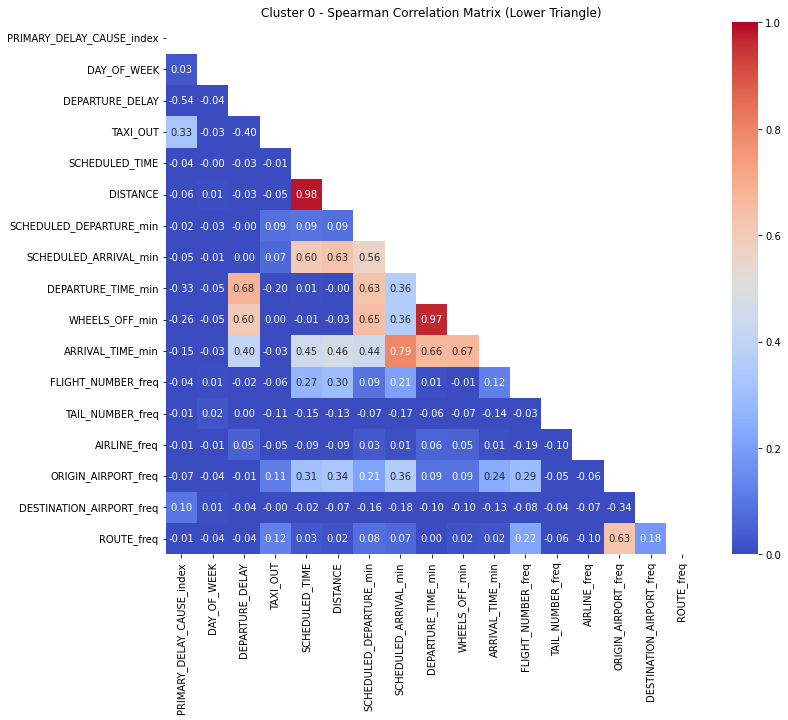


--- Cluster 1 ---


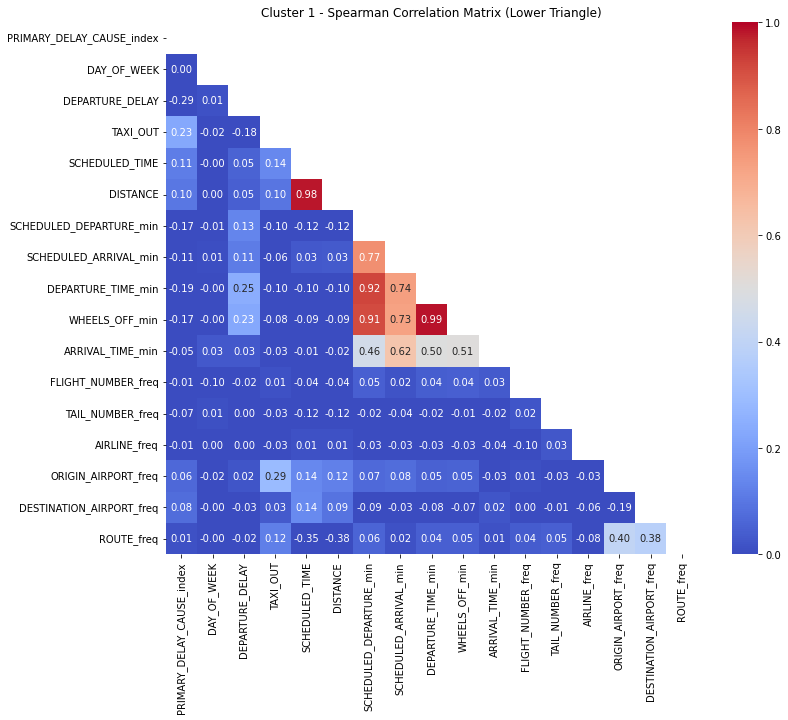


--- Cluster 2 ---


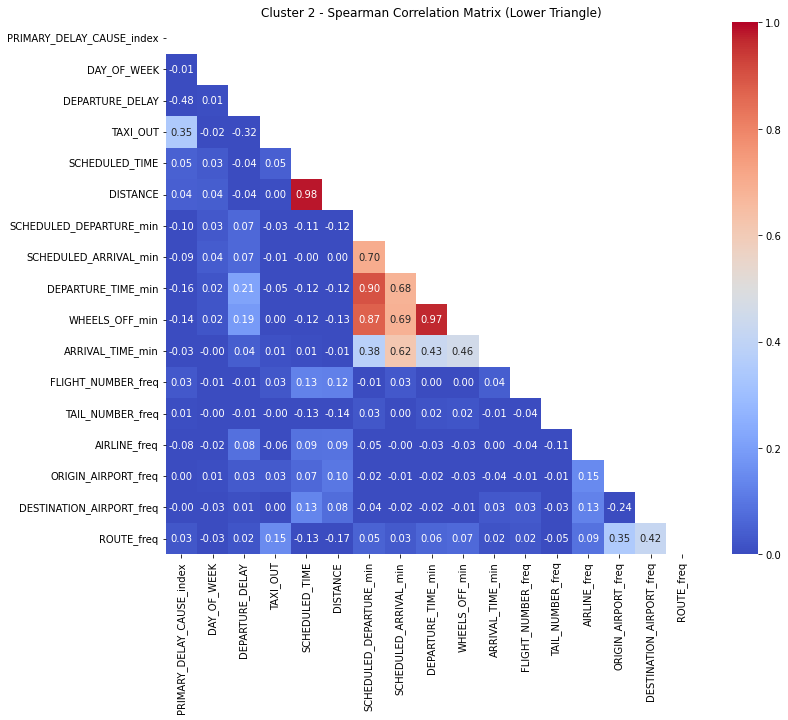


--- Cluster 3 ---


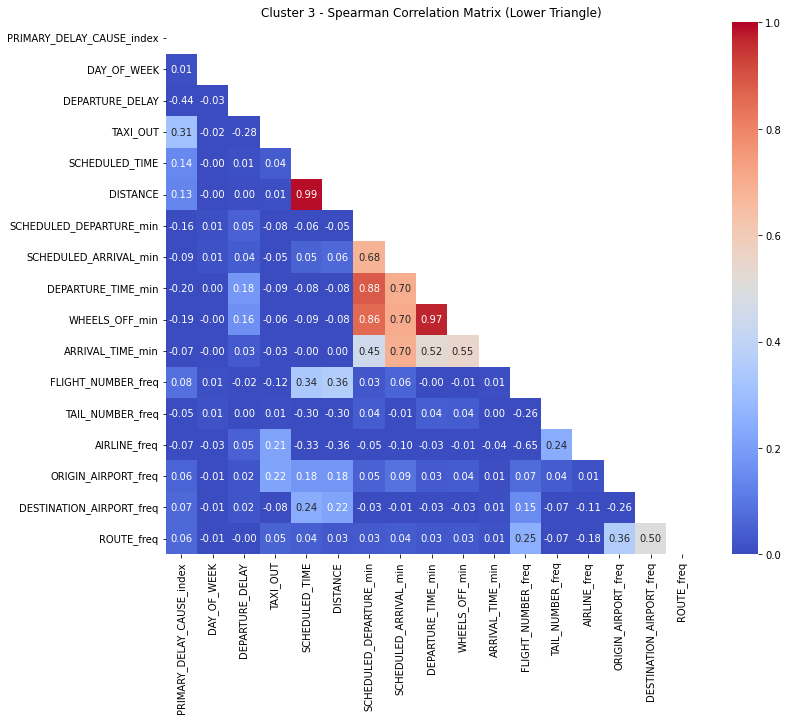


--- Cluster 4 ---


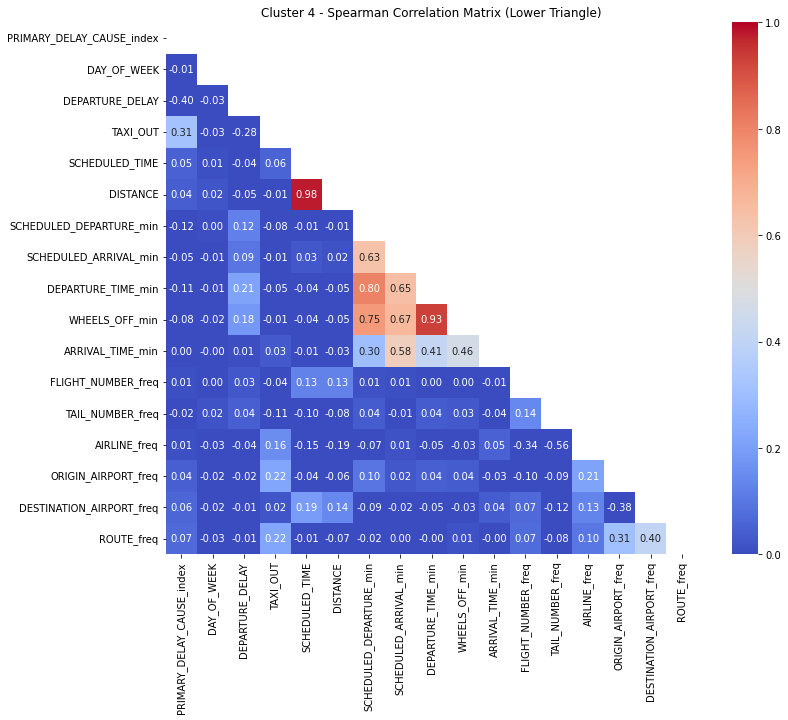


--- Cluster 5 ---


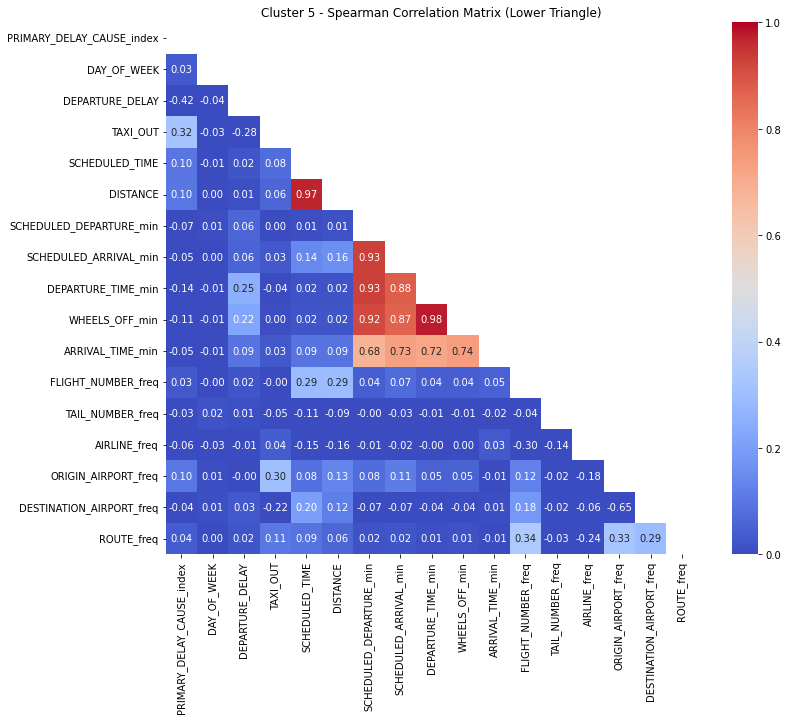

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Loop through each cluster
for cluster_id, cluster_df in train_dfs_by_cluster.items():
    print(f"\n--- Cluster {cluster_id} ---")

    # Final list of features (target first)
    features_for_corr = [target_column] + non_binary_numerical

    # Assemble features
    assembler = VectorAssembler(inputCols=features_for_corr, outputCol="features_with_target")
    assembled = assembler.transform(cluster_df)

    # Compute Spearman correlation
    corr_matrix = Correlation.corr(assembled, "features_with_target", method="spearman").collect()[0][0]
    corr_array = corr_matrix.toArray()

    # Create pandas DataFrame for visualization
    corr_df = pd.DataFrame(corr_array, columns=features_for_corr, index=features_for_corr)

    # Mask the upper triangle
    mask = np.triu(np.ones_like(corr_df, dtype=bool))

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_df, 
        mask=mask, 
        annot=True, 
        cmap="coolwarm", 
        fmt=".2f", 
        square=True,
        vmin=0, vmax=1
    )
    plt.title(f"Cluster {cluster_id} - Spearman Correlation Matrix (Lower Triangle)")
    plt.tight_layout()
    plt.show()

### 5.11.1.2 After

Threshold between features (to exclude): >= |0.80|

Threshold features with target (to exclude): <= |0.10|

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col
import numpy as np

# Define exclusion lists per cluster
high_corr_features_per_cluster = {
    0: ['SCHEDULED_TIME', 'DEPARTURE_TIME_min'],
    1: ['SCHEDULED_TIME', 'DEPARTURE_TIME_min', 'SCHEDULED_DEPARTURE_min'],
    2: ['SCHEDULED_TIME', 'DEPARTURE_TIME_min', 'SCHEDULED_DEPARTURE_min'],
    3: ['SCHEDULED_TIME', 'DEPARTURE_TIME_min', 'SCHEDULED_DEPARTURE_min'],
    4: ['SCHEDULED_TIME', 'DEPARTURE_TIME_min'],
    5: ['SCHEDULED_TIME', 'DEPARTURE_TIME_min', 'SCHEDULED_DEPARTURE_min', 'SCHEDULED_ARRIVAL_min'],
}

# Threshold for weak correlation with target
corr_threshold_with_target = 0.1

# Dictionary to store selected features per cluster
selected_features_spearman_by_cluster = {}

for cluster_id in cluster_ids:
    print(f"\n--- Cluster {cluster_id} ---")

    cluster_df = train_dfs_by_cluster[cluster_id]

    # Get high-correlated features
    high_corr_features = high_corr_features_per_cluster.get(cluster_id, [])

    # Compute Spearman correlation
    features_to_test = [target_column] + non_binary_numerical
    assembler = VectorAssembler(inputCols=features_to_test, outputCol="features_with_target")
    assembled = assembler.transform(cluster_df)

    corr_matrix = Correlation.corr(assembled, "features_with_target", method="spearman").collect()[0][0]
    corr_array = corr_matrix.toArray()

    # Target is at index 0
    correlations_with_target = corr_array[0, 1:]  # skip self-correlation

    low_corr_features_with_target = [
        feature for feature, corr in zip(non_binary_numerical, correlations_with_target)
        if abs(corr) <= corr_threshold_with_target
    ]

    # Combine exclusions and deduplicate
    total_excluded = list(set(high_corr_features + low_corr_features_with_target))

    # Final selected features
    selected = [col_name for col_name in non_binary_numerical if col_name not in total_excluded]

    selected_features_spearman_by_cluster[cluster_id] = selected

    print("High-correlation exclusions:")
    print(high_corr_features)
    print("Low-correlation with target exclusions:")
    print(low_corr_features_with_target)
    print("Selected features:")
    print(selected)


--- Cluster 0 ---
High-correlation exclusions:
['SCHEDULED_TIME', 'DEPARTURE_TIME_min']
Low-correlation with target exclusions:
['DAY_OF_WEEK', 'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_DEPARTURE_min', 'SCHEDULED_ARRIVAL_min', 'FLIGHT_NUMBER_freq', 'TAIL_NUMBER_freq', 'AIRLINE_freq', 'ORIGIN_AIRPORT_freq', 'DESTINATION_AIRPORT_freq', 'ROUTE_freq']
Selected features:
['DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF_min', 'ARRIVAL_TIME_min']

--- Cluster 1 ---
High-correlation exclusions:
['SCHEDULED_TIME', 'DEPARTURE_TIME_min', 'SCHEDULED_DEPARTURE_min']
Low-correlation with target exclusions:
['DAY_OF_WEEK', 'ARRIVAL_TIME_min', 'FLIGHT_NUMBER_freq', 'TAIL_NUMBER_freq', 'AIRLINE_freq', 'ORIGIN_AIRPORT_freq', 'DESTINATION_AIRPORT_freq', 'ROUTE_freq']
Selected features:
['DEPARTURE_DELAY', 'TAXI_OUT', 'DISTANCE', 'SCHEDULED_ARRIVAL_min', 'WHEELS_OFF_min']

--- Cluster 2 ---
High-correlation exclusions:
['SCHEDULED_TIME', 'DEPARTURE_TIME_min', 'SCHEDULED_DEPARTURE_min']
Low-correlation with tar


--- Cluster 0 ---


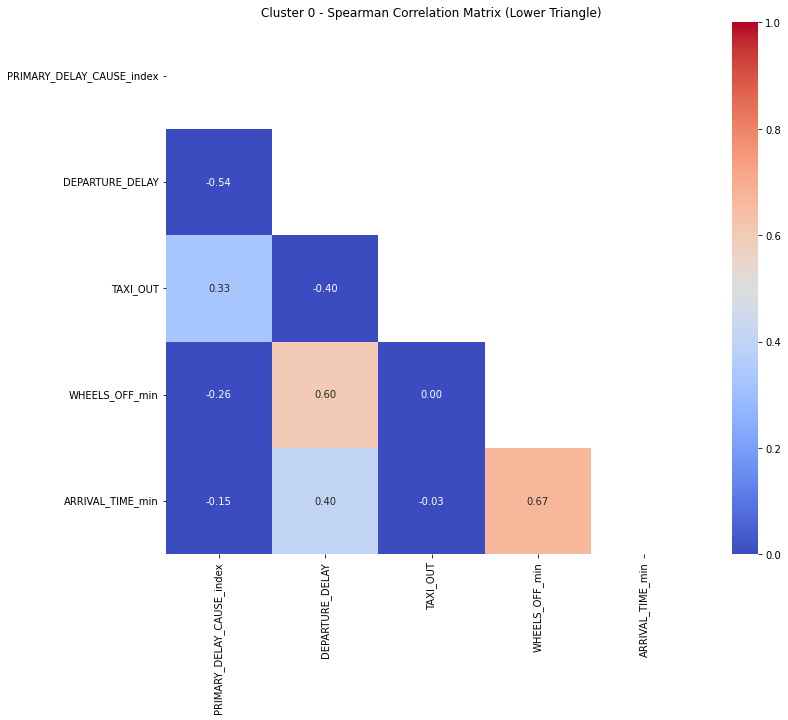


--- Cluster 1 ---


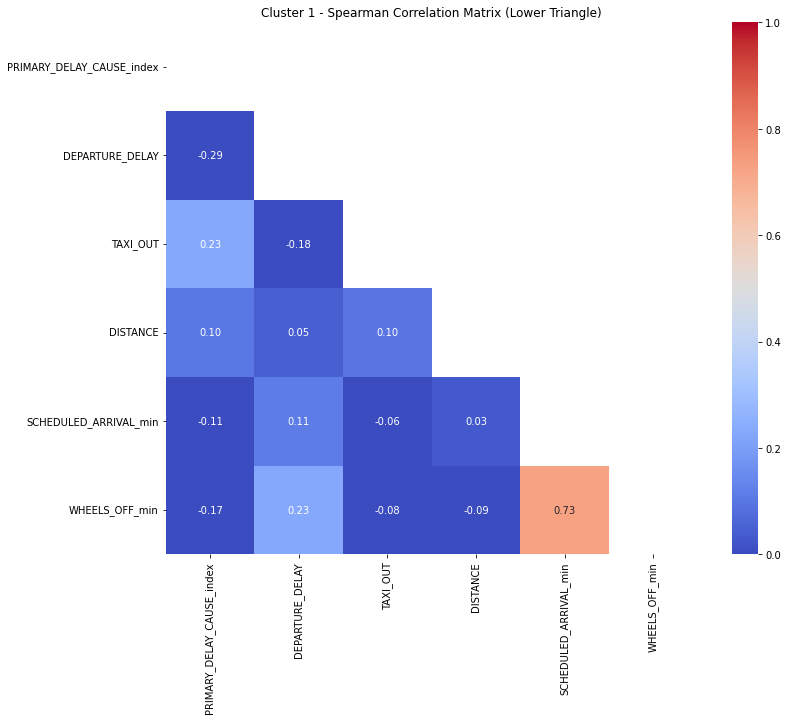


--- Cluster 2 ---


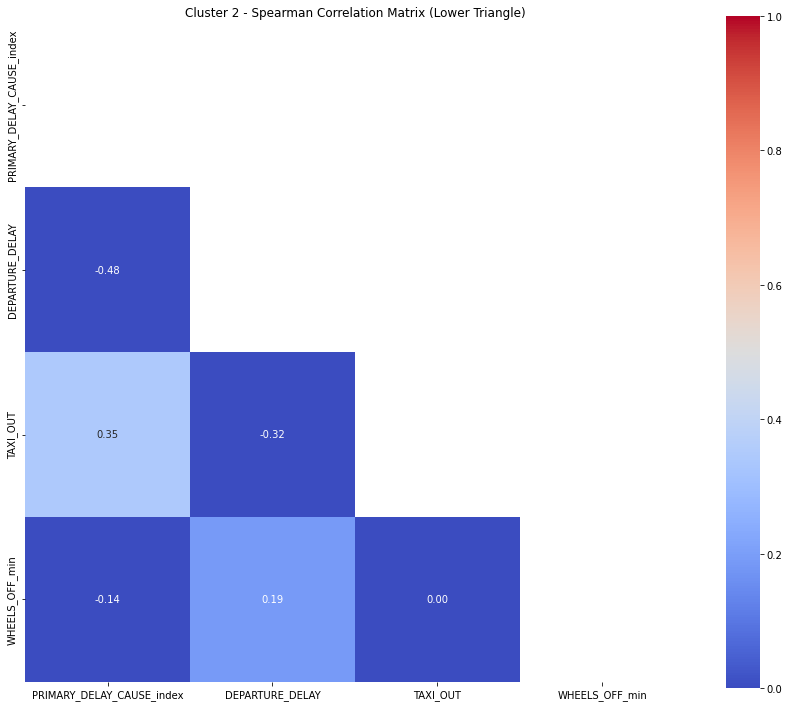


--- Cluster 3 ---


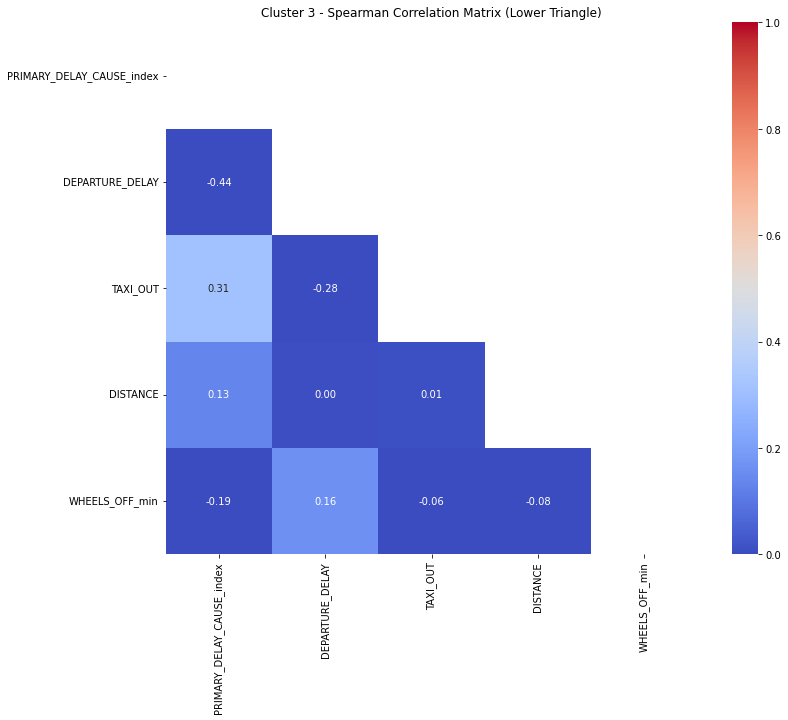


--- Cluster 4 ---


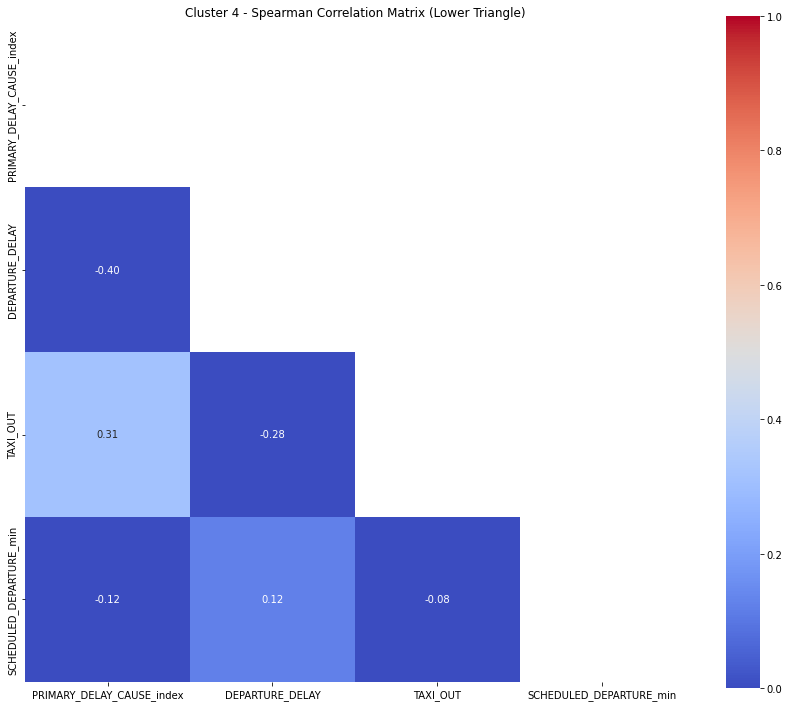


--- Cluster 5 ---


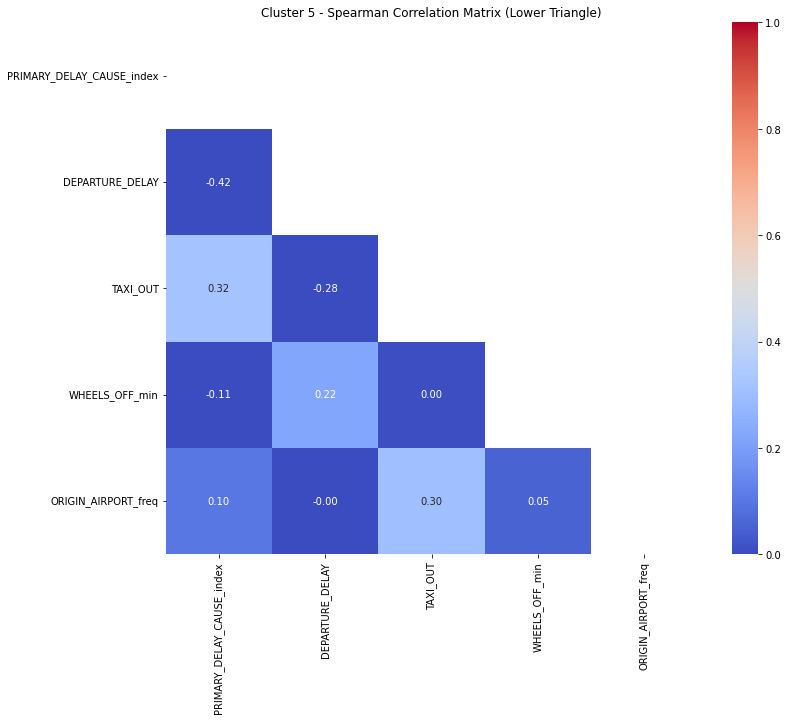

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Loop through each cluster
for cluster_id, cluster_df in train_dfs_by_cluster.items():
    print(f"\n--- Cluster {cluster_id} ---")

    # Final list of selected features (and target)
    features_for_corr = [target_column] + selected_features_spearman_by_cluster[cluster_id]

    # Assemble features
    assembler = VectorAssembler(inputCols=features_for_corr, outputCol="features_with_target")
    assembled = assembler.transform(cluster_df)

    # Compute Spearman correlation
    corr_matrix = Correlation.corr(assembled, "features_with_target", method="spearman").collect()[0][0]
    corr_array = corr_matrix.toArray()

    # Create pandas DataFrame for visualization
    corr_df = pd.DataFrame(corr_array, columns=features_for_corr, index=features_for_corr)

    # Mask the upper triangle
    mask = np.triu(np.ones_like(corr_df, dtype=bool))

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_df, 
        mask=mask, 
        annot=True, 
        cmap="coolwarm", 
        fmt=".2f", 
        square=True,
        vmin=0, vmax=1
    )
    plt.title(f"Cluster {cluster_id} - Spearman Correlation Matrix (Lower Triangle)")
    plt.tight_layout()
    plt.show()

## 5.11.2 RFE selection

### 5.11.2.1 Functions

In [0]:
# Function to decode predictions (add true_label and predicted_label columns)
def decode_predictions(df):
    df = IndexToString(inputCol="prediction", outputCol="predicted_label", labels=target_indexer_model.labels).transform(df)
    df = IndexToString(inputCol=target_column, outputCol="true_label", labels=target_indexer_model.labels).transform(df)
    return df

In [0]:
# Function to compute macro F1
def compute_macro_f1(decoded_df):
    import pyspark.sql.functions as F

    # Compute confusion matrix
    cm = decoded_df.groupBy("true_label", "predicted_label").count()

    # Extract TP (where prediction == true)
    tp = cm.filter(F.col("true_label") == F.col("predicted_label")) \
           .select(F.col("true_label").alias("label"), F.col("count").alias("tp")).alias("tp")

    # Count true labels per class
    total_true = cm.groupBy("true_label").agg(F.sum("count").alias("true_total")) \
                   .select(F.col("true_label").alias("label"), "true_total").alias("true_total")

    # Count predicted labels per class
    total_pred = cm.groupBy("predicted_label").agg(F.sum("count").alias("pred_total")) \
                   .select(F.col("predicted_label").alias("label"), "pred_total").alias("total_pred")

    # Join all metrics on label
    metrics = total_true.join(tp, on="label", how="outer") \
                        .join(total_pred, on="label", how="outer") \
                        .select(
                            F.col("label"),
                            F.coalesce(F.col("tp.tp"), F.lit(0)).alias("tp"),
                            F.coalesce(F.col("true_total.true_total"), F.lit(0)).alias("true_total"),
                            F.coalesce(F.col("total_pred.pred_total"), F.lit(0)).alias("pred_total")
                        )

    # Compute precision, recall, F1 per class
    metrics = metrics.withColumn("precision", F.when(F.col("pred_total") != 0, F.col("tp") / F.col("pred_total")).otherwise(0))
    metrics = metrics.withColumn("recall", F.when(F.col("true_total") != 0, F.col("tp") / F.col("true_total")).otherwise(0))
    metrics = metrics.withColumn("f1", F.when(
        (F.col("precision") + F.col("recall")) > 0,
        2 * (F.col("precision") * F.col("recall")) / (F.col("precision") + F.col("recall"))
    ).otherwise(0))

    # Average F1 across classes
    macro_f1 = metrics.select(F.avg("f1")).first()[0]

    return macro_f1

### 5.11.2.2 Choose Number of Features to Select


--- Cluster 0 ---
Removed: IS_WEEKEND (importance: 0.000214, F1-train: 0.3798, F1-val: 0.4319)
Removed: DAY_OF_WEEK (importance: 0.002450, F1-train: 0.3949, F1-val: 0.4485)
Removed: ROUTE_freq (importance: 0.002416, F1-train: 0.3729, F1-val: 0.4242)
Removed: SCHEDULED_TIME (importance: 0.003105, F1-train: 0.3830, F1-val: 0.4241)
Removed: TAIL_NUMBER_freq (importance: 0.003484, F1-train: 0.4155, F1-val: 0.4249)
Removed: ORIGIN_AIRPORT_freq (importance: 0.004054, F1-train: 0.4033, F1-val: 0.4452)
Removed: DESTINATION_AIRPORT_freq (importance: 0.002819, F1-train: 0.4375, F1-val: 0.4468)
Removed: FLIGHT_NUMBER_freq (importance: 0.006294, F1-train: 0.4351, F1-val: 0.4626)
Removed: SCHEDULED_ARRIVAL_min (importance: 0.006674, F1-train: 0.4122, F1-val: 0.4452)
Removed: DISTANCE (importance: 0.009489, F1-train: 0.3887, F1-val: 0.4619)
Removed: ARRIVAL_TIME_min (importance: 0.008252, F1-train: 0.4044, F1-val: 0.4692)
Removed: SCHEDULED_DEPARTURE_min (importance: 0.020299, F1-train: 0.4129, F1-

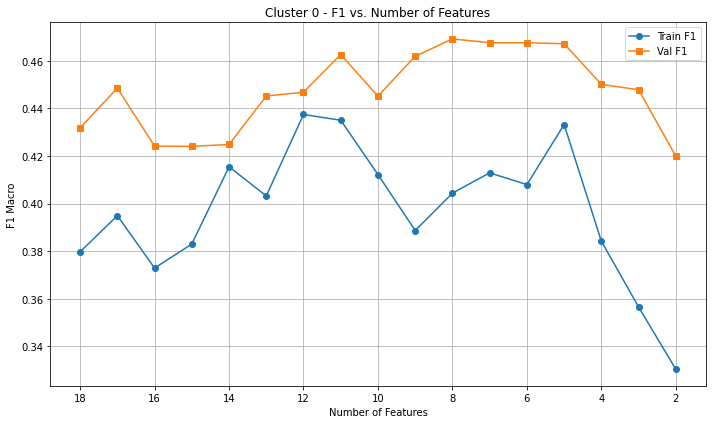


--- Cluster 1 ---
Removed: IS_WEEKEND (importance: 0.000683, F1-train: 0.3249, F1-val: 0.4040)
Removed: AIRLINE_freq (importance: 0.001328, F1-train: 0.3343, F1-val: 0.4239)
Removed: DAY_OF_WEEK (importance: 0.001511, F1-train: 0.3280, F1-val: 0.4156)
Removed: ARRIVAL_TIME_min (importance: 0.002786, F1-train: 0.3309, F1-val: 0.4143)
Removed: FLIGHT_NUMBER_freq (importance: 0.003364, F1-train: 0.3246, F1-val: 0.3995)
Removed: SCHEDULED_ARRIVAL_min (importance: 0.005050, F1-train: 0.3275, F1-val: 0.4064)
Removed: TAIL_NUMBER_freq (importance: 0.003506, F1-train: 0.3340, F1-val: 0.4237)
Removed: ROUTE_freq (importance: 0.006409, F1-train: 0.3341, F1-val: 0.4219)
Removed: DESTINATION_AIRPORT_freq (importance: 0.005317, F1-train: 0.3362, F1-val: 0.4230)
Removed: WHEELS_OFF_min (importance: 0.014987, F1-train: 0.3378, F1-val: 0.4282)
Removed: SCHEDULED_TIME (importance: 0.011974, F1-train: 0.3365, F1-val: 0.4241)
Removed: DISTANCE (importance: 0.016769, F1-train: 0.3371, F1-val: 0.4204)
Rem

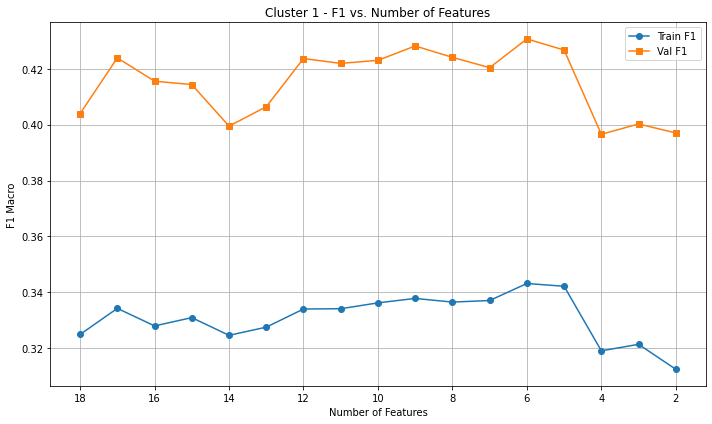


--- Cluster 2 ---
Removed: IS_WEEKEND (importance: 0.001007, F1-train: 0.3843, F1-val: 0.3813)
Removed: DAY_OF_WEEK (importance: 0.001216, F1-train: 0.3812, F1-val: 0.3779)
Removed: FLIGHT_NUMBER_freq (importance: 0.003498, F1-train: 0.3774, F1-val: 0.3787)
Removed: TAIL_NUMBER_freq (importance: 0.002638, F1-train: 0.3791, F1-val: 0.3743)
Removed: DISTANCE (importance: 0.002618, F1-train: 0.3789, F1-val: 0.3733)
Removed: AIRLINE_freq (importance: 0.000602, F1-train: 0.3838, F1-val: 0.3800)
Removed: ROUTE_freq (importance: 0.006014, F1-train: 0.3814, F1-val: 0.3727)
Removed: ARRIVAL_TIME_min (importance: 0.004320, F1-train: 0.3910, F1-val: 0.3837)
Removed: SCHEDULED_TIME (importance: 0.007485, F1-train: 0.3832, F1-val: 0.3754)
Removed: SCHEDULED_ARRIVAL_min (importance: 0.010274, F1-train: 0.3851, F1-val: 0.3801)
Removed: ORIGIN_AIRPORT_freq (importance: 0.008751, F1-train: 0.3845, F1-val: 0.3867)
Removed: WHEELS_OFF_min (importance: 0.019268, F1-train: 0.3909, F1-val: 0.3910)
Removed:

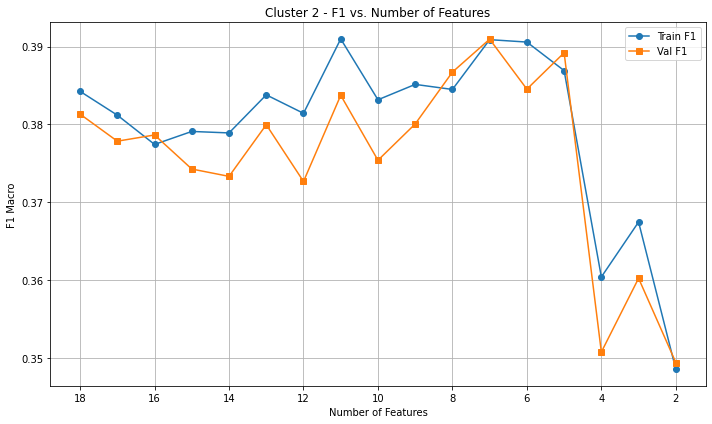


--- Cluster 3 ---
Removed: IS_WEEKEND (importance: 0.000314, F1-train: 0.3680, F1-val: 0.3577)
Removed: DAY_OF_WEEK (importance: 0.000864, F1-train: 0.3694, F1-val: 0.3595)
Removed: TAIL_NUMBER_freq (importance: 0.003281, F1-train: 0.3670, F1-val: 0.3591)
Removed: FLIGHT_NUMBER_freq (importance: 0.003182, F1-train: 0.3691, F1-val: 0.3599)
Removed: ARRIVAL_TIME_min (importance: 0.004266, F1-train: 0.3687, F1-val: 0.3575)
Removed: ROUTE_freq (importance: 0.003573, F1-train: 0.3677, F1-val: 0.3566)
Removed: SCHEDULED_ARRIVAL_min (importance: 0.010588, F1-train: 0.3689, F1-val: 0.3572)
Removed: SCHEDULED_TIME (importance: 0.017657, F1-train: 0.3736, F1-val: 0.3653)
Removed: ORIGIN_AIRPORT_freq (importance: 0.015714, F1-train: 0.3690, F1-val: 0.3593)
Removed: SCHEDULED_DEPARTURE_min (importance: 0.022425, F1-train: 0.3697, F1-val: 0.3563)
Removed: DESTINATION_AIRPORT_freq (importance: 0.029635, F1-train: 0.3707, F1-val: 0.3616)
Removed: DISTANCE (importance: 0.034352, F1-train: 0.3695, F1-

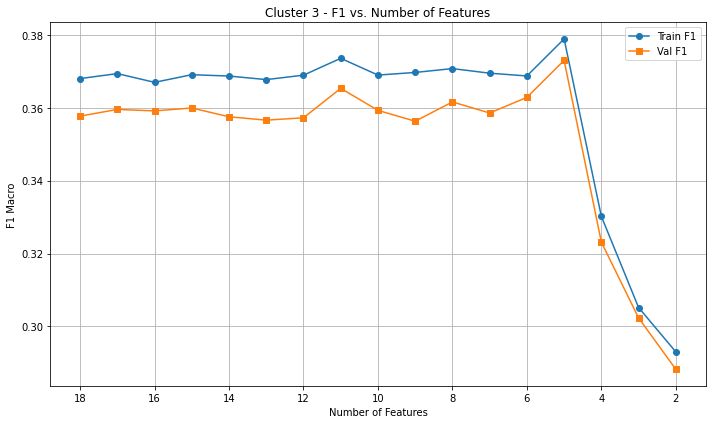


--- Cluster 4 ---
Removed: IS_WEEKEND (importance: 0.000579, F1-train: 0.3684, F1-val: 0.3519)
Removed: DAY_OF_WEEK (importance: 0.002122, F1-train: 0.3705, F1-val: 0.3551)
Removed: FLIGHT_NUMBER_freq (importance: 0.003439, F1-train: 0.3640, F1-val: 0.3502)
Removed: DISTANCE (importance: 0.002896, F1-train: 0.3704, F1-val: 0.3520)
Removed: ARRIVAL_TIME_min (importance: 0.003738, F1-train: 0.3715, F1-val: 0.3551)
Removed: ROUTE_freq (importance: 0.003588, F1-train: 0.3682, F1-val: 0.3470)
Removed: WHEELS_OFF_min (importance: 0.004315, F1-train: 0.3719, F1-val: 0.3550)
Removed: TAIL_NUMBER_freq (importance: 0.005433, F1-train: 0.3716, F1-val: 0.3538)
Removed: SCHEDULED_ARRIVAL_min (importance: 0.004941, F1-train: 0.3727, F1-val: 0.3571)
Removed: SCHEDULED_TIME (importance: 0.008270, F1-train: 0.3652, F1-val: 0.3477)
Removed: DEPARTURE_TIME_min (importance: 0.013497, F1-train: 0.3693, F1-val: 0.3546)
Removed: AIRLINE_freq (importance: 0.028133, F1-train: 0.3744, F1-val: 0.3603)
Removed: 

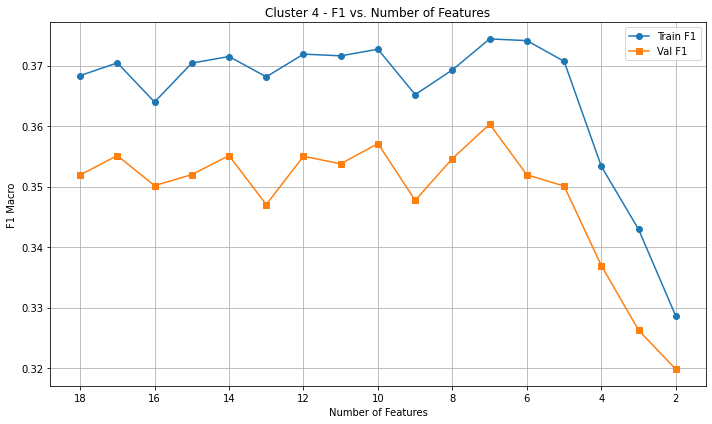


--- Cluster 5 ---
Removed: IS_WEEKEND (importance: 0.000000, F1-train: 0.3509, F1-val: 0.3165)
Removed: DAY_OF_WEEK (importance: 0.001415, F1-train: 0.3488, F1-val: 0.3137)
Removed: FLIGHT_NUMBER_freq (importance: 0.001844, F1-train: 0.3429, F1-val: 0.3109)
Removed: TAIL_NUMBER_freq (importance: 0.002220, F1-train: 0.3519, F1-val: 0.3158)
Removed: ROUTE_freq (importance: 0.002210, F1-train: 0.3524, F1-val: 0.3161)
Removed: ARRIVAL_TIME_min (importance: 0.003308, F1-train: 0.3549, F1-val: 0.3164)
Removed: SCHEDULED_TIME (importance: 0.005412, F1-train: 0.3498, F1-val: 0.3137)
Removed: WHEELS_OFF_min (importance: 0.005136, F1-train: 0.3471, F1-val: 0.3166)
Removed: DISTANCE (importance: 0.008463, F1-train: 0.3531, F1-val: 0.3178)
Removed: AIRLINE_freq (importance: 0.009077, F1-train: 0.3486, F1-val: 0.3177)
Removed: SCHEDULED_ARRIVAL_min (importance: 0.015369, F1-train: 0.3526, F1-val: 0.3139)
Removed: DEPARTURE_TIME_min (importance: 0.018786, F1-train: 0.3549, F1-val: 0.3255)
Removed: 

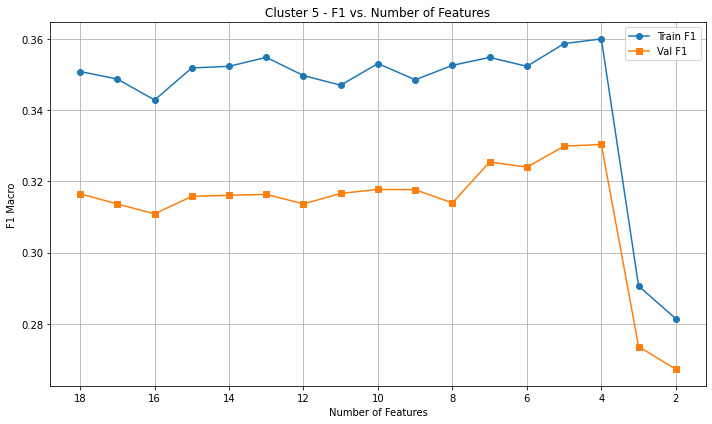

In [0]:
from pyspark.ml.feature import VectorAssembler, IndexToString
from pyspark.ml.classification import RandomForestClassifier
import matplotlib.pyplot as plt

for cluster_id in cluster_ids:
    print(f"\n--- Cluster {cluster_id} ---")
    
    cluster_train_df = train_dfs_by_cluster[cluster_id]
    cluster_val_df = val_dfs_by_cluster[cluster_id]
    features = [f for f in numerical_columns if f in cluster_train_df.columns]

    features_history = []
    train_f1_history = []
    val_f1_history = []
    
    excluded_features = []

    while len(features) > 1:
        assembler = VectorAssembler(inputCols=features, outputCol="features_temp")
        
        # Assemble both train and val
        train_assembled = assembler.transform(cluster_train_df).select("features_temp", "PRIMARY_DELAY_CAUSE_index")
        val_assembled = assembler.transform(cluster_val_df).select("features_temp", "PRIMARY_DELAY_CAUSE_index")

        rf = RandomForestClassifier(featuresCol="features_temp", labelCol="PRIMARY_DELAY_CAUSE_index", seed=42)
        model = rf.fit(train_assembled)

        # Predict train and val
        train_preds = decode_predictions(model.transform(train_assembled))
        val_preds = decode_predictions(model.transform(val_assembled))

        # Compute metrics
        train_f1 = compute_macro_f1(train_preds)
        val_f1 = compute_macro_f1(val_preds)

        # Store history
        features_history.append(features.copy())
        train_f1_history.append(train_f1)
        val_f1_history.append(val_f1)

        # Remove least important
        importances = model.featureImportances.toArray()
        feature_importance_dict = dict(zip(features, importances))
        least_important = sorted(feature_importance_dict.items(), key=lambda x: x[1])[0][0]

        print(f"Removed: {least_important} (importance: {feature_importance_dict[least_important]:.6f}, F1-train: {train_f1:.4f}, F1-val: {val_f1:.4f})")
        features.remove(least_important)
        excluded_features.append(least_important)

    # Plot elbow
    plt.figure(figsize=(10, 6))
    plt.plot([len(f) for f in features_history], train_f1_history, label="Train F1", marker='o')
    plt.plot([len(f) for f in features_history], val_f1_history, label="Val F1", marker='s')
    plt.xlabel("Number of Features")
    plt.ylabel("F1 Macro")
    plt.title(f"Cluster {cluster_id} - F1 vs. Number of Features")
    plt.gca().invert_xaxis()
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 5.11.2.3 RFE

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

# Define number of features to select per cluster (based on previous elbows)
target_num_features_by_cluster = {
    0: 5,
    1: 5,
    2: 7,
    3: 5,
    4: 7,
    5: 4
}

# Result storage
selected_features_rfe_by_cluster = {}
excluded_features_rfe_by_cluster = {}

for cluster_id in cluster_ids:
    print(f"\n--- Cluster {cluster_id} ---")
    
    cluster_train_df = train_dfs_by_cluster[cluster_id]
    target_num_features = target_num_features_by_cluster.get(cluster_id, 5)  # fallback to 5

    # Start with features that exist in the DataFrame
    features = [f for f in numerical_columns if f in cluster_train_df.columns]
    excluded_features_rfe = []

    while len(features) > target_num_features:
        assembler = VectorAssembler(inputCols=features, outputCol="features_temp")
        assembled_df = assembler.transform(cluster_train_df).select("features_temp", "PRIMARY_DELAY_CAUSE_index")

        rf = RandomForestRegressor(featuresCol="features_temp", labelCol="PRIMARY_DELAY_CAUSE_index", seed=42)
        model = rf.fit(assembled_df)

        importances = model.featureImportances.toArray()
        feature_importance_dict = dict(zip(features, importances))

        # Remove least important feature
        least_important = sorted(feature_importance_dict.items(), key=lambda x: x[1])[0][0]
        print(f"Removed: {least_important} (importance: {feature_importance_dict[least_important]:.6f})")

        features.remove(least_important)
        excluded_features_rfe.append(least_important)

    selected_features_rfe_by_cluster[cluster_id] = features
    excluded_features_rfe_by_cluster[cluster_id] = excluded_features_rfe

    print(f"Cluster {cluster_id} - Selected features: {features}")


--- Cluster 0 ---
Removed: IS_WEEKEND (importance: 0.002854)
Removed: ROUTE_freq (importance: 0.005733)
Removed: DAY_OF_WEEK (importance: 0.006597)
Removed: TAIL_NUMBER_freq (importance: 0.007993)
Removed: FLIGHT_NUMBER_freq (importance: 0.011972)
Removed: ARRIVAL_TIME_min (importance: 0.015263)
Removed: DESTINATION_AIRPORT_freq (importance: 0.018244)
Removed: ORIGIN_AIRPORT_freq (importance: 0.019821)
Removed: SCHEDULED_ARRIVAL_min (importance: 0.020712)
Removed: SCHEDULED_DEPARTURE_min (importance: 0.030610)
Removed: WHEELS_OFF_min (importance: 0.035686)
Removed: SCHEDULED_TIME (importance: 0.035560)
Removed: AIRLINE_freq (importance: 0.046880)
Cluster 0 - Selected features: ['DEPARTURE_DELAY', 'TAXI_OUT', 'DISTANCE', 'DELAYED_DEPARTURE_FLAG', 'DEPARTURE_TIME_min']

--- Cluster 1 ---
Removed: IS_WEEKEND (importance: 0.000007)
Removed: AIRLINE_freq (importance: 0.000537)
Removed: ARRIVAL_TIME_min (importance: 0.002381)
Removed: DAY_OF_WEEK (importance: 0.001612)
Removed: FLIGHT_NUMBE

## 5.11.3 DT Selection

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.sql.functions import lit
from pyspark.sql import Row

# Store results per cluster
selected_features_dt_by_cluster = {}
excluded_features_dt_by_cluster = {}

for cluster_id in cluster_ids:
    print(f"\n--- Cluster {cluster_id} ---")

    # Get cluster-specific train data
    cluster_train_df = train_dfs_by_cluster[cluster_id]

    # Copy features list
    features = [f for f in numerical_columns if f in cluster_train_df.columns]

    # Assemble features
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    train_vectorized = assembler.transform(cluster_train_df).select("features", "PRIMARY_DELAY_CAUSE_index")

    # Train Decision Tree Regressor
    dt = DecisionTreeRegressor(featuresCol="features", labelCol="PRIMARY_DELAY_CAUSE_index", seed=42)
    dt_model = dt.fit(train_vectorized)

    # Extract feature importances
    importances = dt_model.featureImportances.toArray()

    # Convert to Spark DataFrame
    importance_rows = [Row(feature=feature, importance=float(score)) for feature, score in zip(features, importances)]
    importance_df = spark.createDataFrame(importance_rows)

    # Filter non-zero and sort descending
    selected_by_tree_df = importance_df.filter("importance > 0").orderBy("importance", ascending=False)

    # Collect selected features into a list
    selected_features_dt = [row["feature"] for row in selected_by_tree_df.collect()]

    # Compute excluded features
    excluded_features_dt = [f for f in features if f not in selected_features_dt]

    # Store per cluster
    selected_features_dt_by_cluster[cluster_id] = selected_features_dt
    excluded_features_dt_by_cluster[cluster_id] = excluded_features_dt

    # Print results
    print(f"Cluster {cluster_id} - DT excluded features: {excluded_features_dt}")
    print(f"Cluster {cluster_id} - DT selected features: {selected_features_dt}")


--- Cluster 0 ---
Cluster 0 - DT excluded features: ['IS_WEEKEND', 'DELAYED_DEPARTURE_FLAG', 'WHEELS_OFF_min', 'FLIGHT_NUMBER_freq', 'TAIL_NUMBER_freq', 'DESTINATION_AIRPORT_freq', 'ROUTE_freq']
Cluster 0 - DT selected features: ['DEPARTURE_DELAY', 'TAXI_OUT', 'DISTANCE', 'ORIGIN_AIRPORT_freq', 'SCHEDULED_TIME', 'DEPARTURE_TIME_min', 'AIRLINE_freq', 'DAY_OF_WEEK', 'ARRIVAL_TIME_min', 'SCHEDULED_ARRIVAL_min', 'SCHEDULED_DEPARTURE_min']

--- Cluster 1 ---
Cluster 1 - DT excluded features: ['IS_WEEKEND', 'DELAYED_DEPARTURE_FLAG', 'SCHEDULED_ARRIVAL_min', 'ARRIVAL_TIME_min', 'TAIL_NUMBER_freq']
Cluster 1 - DT selected features: ['DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_DEPARTURE_min', 'ORIGIN_AIRPORT_freq', 'DISTANCE', 'DEPARTURE_TIME_min', 'SCHEDULED_TIME', 'DESTINATION_AIRPORT_freq', 'FLIGHT_NUMBER_freq', 'ROUTE_freq', 'WHEELS_OFF_min', 'DAY_OF_WEEK', 'AIRLINE_freq']

--- Cluster 2 ---
Cluster 2 - DT excluded features: ['DISTANCE', 'IS_WEEKEND', 'SCHEDULED_ARRIVAL_min', 'DEPARTURE_TIME

## 5.11.4 Lasso Selection

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

selected_features_lasso_by_cluster = {}
excluded_features_lasso_by_cluster = {}

for cluster_id in cluster_ids:
    print(f"\n--- Cluster {cluster_id} ---")

    # Get cluster-specific train data
    cluster_train_df = train_dfs_by_cluster[cluster_id]

    # Check features actually present in this cluster df
    features = [f for f in numerical_columns if f in cluster_train_df.columns]

    # Assemble features vector
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    train_data = assembler.transform(cluster_train_df).select("features", "PRIMARY_DELAY_CAUSE_index")

    # Rename label column for LinearRegression
    train_data = train_data.withColumnRenamed("PRIMARY_DELAY_CAUSE_index", "label")

    # Initialize Lasso (elasticNetParam=1.0 for Lasso)
    lasso = LinearRegression(featuresCol="features", labelCol="label", elasticNetParam=1.0, regParam=0.1)

    # Fit model
    lasso_model = lasso.fit(train_data)

    # Get coefficients as array
    coefficients = lasso_model.coefficients.toArray()

    # Identify selected and excluded features based on coefficients
    selected_features = [f for f, coef in zip(features, coefficients) if coef != 0]
    excluded_features = [f for f, coef in zip(features, coefficients) if coef == 0]

    # Store results
    selected_features_lasso_by_cluster[cluster_id] = selected_features
    excluded_features_lasso_by_cluster[cluster_id] = excluded_features

    # Print for this cluster
    print(f"Cluster {cluster_id} - Lasso excluded features: {excluded_features}")
    print(f"Cluster {cluster_id} - Lasso selected features: {selected_features}")


--- Cluster 0 ---
Cluster 0 - Lasso excluded features: ['DAY_OF_WEEK', 'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'DISTANCE', 'IS_WEEKEND', 'SCHEDULED_DEPARTURE_min', 'SCHEDULED_ARRIVAL_min', 'DEPARTURE_TIME_min', 'WHEELS_OFF_min', 'ARRIVAL_TIME_min', 'FLIGHT_NUMBER_freq', 'TAIL_NUMBER_freq', 'AIRLINE_freq', 'ORIGIN_AIRPORT_freq', 'DESTINATION_AIRPORT_freq', 'ROUTE_freq']
Cluster 0 - Lasso selected features: ['TAXI_OUT', 'DELAYED_DEPARTURE_FLAG']

--- Cluster 1 ---
Cluster 1 - Lasso excluded features: ['DAY_OF_WEEK', 'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'DISTANCE', 'IS_WEEKEND', 'SCHEDULED_ARRIVAL_min', 'DEPARTURE_TIME_min', 'WHEELS_OFF_min', 'ARRIVAL_TIME_min', 'FLIGHT_NUMBER_freq', 'TAIL_NUMBER_freq', 'AIRLINE_freq', 'ORIGIN_AIRPORT_freq', 'DESTINATION_AIRPORT_freq', 'ROUTE_freq']
Cluster 1 - Lasso selected features: ['TAXI_OUT', 'DELAYED_DEPARTURE_FLAG', 'SCHEDULED_DEPARTURE_min']

--- Cluster 2 ---
Cluster 2 - Lasso excluded features: ['DAY_OF_WEEK', 'DEPARTURE_DELAY', 'SCHEDULED_TIME',

## 5.11.5 Majority Voting

In [0]:
from collections import Counter
from itertools import chain

majority_voted_features_by_cluster = {}
excluded_majority_features_by_cluster = {}

methods = [
    'spearman',
    'rfe',
    'dt',
    'lasso'
]

for cluster_id in cluster_ids:
    print(f"\n--- Cluster {cluster_id} ---")

    # Collect features selected by each method for this cluster
    feature_lists = [
        selected_features_spearman_by_cluster.get(cluster_id, []),
        selected_features_rfe_by_cluster.get(cluster_id, []),
        selected_features_dt_by_cluster.get(cluster_id, []),
        selected_features_lasso_by_cluster.get(cluster_id, [])
    ]

    # Flatten and count occurrences
    all_selected = list(chain.from_iterable(feature_lists))
    feature_counts = Counter(all_selected)

    # Majority threshold (at least half)
    threshold = len(feature_lists) // 2

    majority_voted_features = [f for f, count in feature_counts.items() if count >= threshold]
    excluded_majority_features = [f for f in feature_counts if f not in majority_voted_features]

    # Store results
    majority_voted_features_by_cluster[cluster_id] = majority_voted_features
    excluded_majority_features_by_cluster[cluster_id] = excluded_majority_features

    # Print cluster results
    print(f"Cluster {cluster_id} - Majority Voting Selected Features:")
    print(majority_voted_features)
    print(f"Cluster {cluster_id} - Majority Voting Excluded Features:")
    print(excluded_majority_features)


--- Cluster 0 ---
Cluster 0 - Majority Voting Selected Features:
['DEPARTURE_DELAY', 'TAXI_OUT', 'ARRIVAL_TIME_min', 'DISTANCE', 'DELAYED_DEPARTURE_FLAG', 'DEPARTURE_TIME_min']
Cluster 0 - Majority Voting Excluded Features:
['WHEELS_OFF_min', 'ORIGIN_AIRPORT_freq', 'SCHEDULED_TIME', 'AIRLINE_freq', 'DAY_OF_WEEK', 'SCHEDULED_ARRIVAL_min', 'SCHEDULED_DEPARTURE_min']

--- Cluster 1 ---
Cluster 1 - Majority Voting Selected Features:
['DEPARTURE_DELAY', 'TAXI_OUT', 'DISTANCE', 'WHEELS_OFF_min', 'DELAYED_DEPARTURE_FLAG', 'SCHEDULED_DEPARTURE_min', 'DEPARTURE_TIME_min']
Cluster 1 - Majority Voting Excluded Features:
['SCHEDULED_ARRIVAL_min', 'ORIGIN_AIRPORT_freq', 'SCHEDULED_TIME', 'DESTINATION_AIRPORT_freq', 'FLIGHT_NUMBER_freq', 'ROUTE_freq', 'DAY_OF_WEEK', 'AIRLINE_freq']

--- Cluster 2 ---
Cluster 2 - Majority Voting Selected Features:
['DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF_min', 'DELAYED_DEPARTURE_FLAG', 'SCHEDULED_DEPARTURE_min', 'ORIGIN_AIRPORT_freq']
Cluster 2 - Majority Voting 

# 5.12 Baseline Models

Excluded models and reasons:
- GBTClassifier: Only supports binary classification in PySpark.
- NaiveBayes: Requires non-negative features and assumes feature independence; not ideal for general tabular data.
- XGBoost: Not natively available in PySpark; requires xgboost4j-spark or external integration.
- AdaBoost: Not implemented in PySpark MLlib; available only in scikit-learn.
- MultilayerPerceptron: Requires manual layer tuning, doesn't support weightCol (class weighting).

In [0]:
# If didn't run feature selection
majority_voted_features_by_cluster = {
    0: ['DEPARTURE_DELAY',
        'TAXI_OUT',
        'ARRIVAL_TIME_min',
        'DISTANCE',
        'DELAYED_DEPARTURE_FLAG',
        'DEPARTURE_TIME_min'],
    1: ['DEPARTURE_DELAY',
        'TAXI_OUT',
        'DISTANCE',
        'WHEELS_OFF_min',
        'DELAYED_DEPARTURE_FLAG',
        'SCHEDULED_DEPARTURE_min',
        'DEPARTURE_TIME_min'],
    2: ['DEPARTURE_DELAY',
        'TAXI_OUT',
        'WHEELS_OFF_min',
        'DELAYED_DEPARTURE_FLAG',
        'SCHEDULED_DEPARTURE_min',
        'ORIGIN_AIRPORT_freq'],
    3: ['DEPARTURE_DELAY',
        'TAXI_OUT',
        'WHEELS_OFF_min',
        'DELAYED_DEPARTURE_FLAG',
        'SCHEDULED_DEPARTURE_min',
        'DEPARTURE_TIME_min'],
    4: ['DEPARTURE_DELAY',
        'TAXI_OUT',
        'SCHEDULED_DEPARTURE_min',
        'SCHEDULED_TIME',
        'DELAYED_DEPARTURE_FLAG',
        'DEPARTURE_TIME_min',
        'ORIGIN_AIRPORT_freq'],
    5: ['DEPARTURE_DELAY',
        'TAXI_OUT',
        'WHEELS_OFF_min',
        'ORIGIN_AIRPORT_freq',
        'DELAYED_DEPARTURE_FLAG']
}

## 5.12.0 Functions

In [0]:
# Function to decode predictions (add true_label and predicted_label columns)
def decode_predictions(df):
    df = IndexToString(inputCol="prediction", outputCol="predicted_label", labels=target_indexer_model.labels).transform(df)
    df = IndexToString(inputCol=target_column, outputCol="true_label", labels=target_indexer_model.labels).transform(df)
    return df

In [0]:
# Function to compute macro F1
def compute_macro_f1(decoded_df):
    import pyspark.sql.functions as F

    # Compute confusion matrix
    cm = decoded_df.groupBy("true_label", "predicted_label").count()

    # Extract TP (where prediction == true)
    tp = cm.filter(F.col("true_label") == F.col("predicted_label")) \
           .select(F.col("true_label").alias("label"), F.col("count").alias("tp")).alias("tp")

    # Count true labels per class
    total_true = cm.groupBy("true_label").agg(F.sum("count").alias("true_total")) \
                   .select(F.col("true_label").alias("label"), "true_total").alias("true_total")

    # Count predicted labels per class
    total_pred = cm.groupBy("predicted_label").agg(F.sum("count").alias("pred_total")) \
                   .select(F.col("predicted_label").alias("label"), "pred_total").alias("total_pred")

    # Join all metrics on label
    metrics = total_true.join(tp, on="label", how="outer") \
                        .join(total_pred, on="label", how="outer") \
                        .select(
                            F.col("label"),
                            F.coalesce(F.col("tp.tp"), F.lit(0)).alias("tp"),
                            F.coalesce(F.col("true_total.true_total"), F.lit(0)).alias("true_total"),
                            F.coalesce(F.col("total_pred.pred_total"), F.lit(0)).alias("pred_total")
                        )

    # Compute precision, recall, F1 per class
    metrics = metrics.withColumn("precision", F.when(F.col("pred_total") != 0, F.col("tp") / F.col("pred_total")).otherwise(0))
    metrics = metrics.withColumn("recall", F.when(F.col("true_total") != 0, F.col("tp") / F.col("true_total")).otherwise(0))
    metrics = metrics.withColumn("f1", F.when(
        (F.col("precision") + F.col("recall")) > 0,
        2 * (F.col("precision") * F.col("recall")) / (F.col("precision") + F.col("recall"))
    ).otherwise(0))

    # Average F1 across classes
    macro_f1 = metrics.select(F.avg("f1")).first()[0]

    return macro_f1

## 5.12.1 Train and Predict

In [0]:
import mlflow
import mlflow.spark
from pyspark.ml.feature import VectorAssembler, IndexToString
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import Row

# Define models with default parameters
default_models = {
    "LogisticRegression": LogisticRegression(featuresCol="features", labelCol=target_column, weightCol="weight", maxIter=100),
    "DecisionTree": DecisionTreeClassifier(featuresCol="features", labelCol=target_column, weightCol="weight", seed=42),
    "RandomForest": RandomForestClassifier(featuresCol="features", labelCol=target_column, weightCol="weight", seed=42),
}

In [0]:
# Set MLflow experiment
mlflow.set_experiment("/Users/marcogalao@outlook.pt/BaselineModels")

# Evaluators
evaluator_f1 = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction", metricName="f1")
evaluator_acc = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction", metricName="accuracy")

# Containers for results and predictions
results = []
train_decoded_predictions = {}  
val_decoded_predictions = {}
models_by_cluster_and_name = {}

for cluster_id in cluster_ids:
    print(f"\n--- Processing Cluster {cluster_id} ---")
    
    train_df = train_dfs_by_cluster[cluster_id]
    val_df = val_dfs_by_cluster[cluster_id]
    features = majority_voted_features_by_cluster[cluster_id]
    
    # Assemble features
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    train_prepared = assembler.transform(train_df)
    val_prepared = assembler.transform(val_df)
    
    for model_name, model in default_models.items():
        print(f"Training {model_name}...")

        with mlflow.start_run(run_name=f"Cluster{cluster_id}_{model_name}"):
            # Fit model
            trained_model = model.fit(train_prepared)

            # Predict on train and val
            train_pred = trained_model.transform(train_prepared)
            val_pred = trained_model.transform(val_prepared)
        
            # Decode predictions
            train_decoded = decode_predictions(train_pred)
            val_decoded = decode_predictions(val_pred)
        
            # Save decoded predictions
            train_decoded_predictions[(cluster_id, model_name)] = train_decoded
            val_decoded_predictions[(cluster_id, model_name)] = val_decoded
            models_by_cluster_and_name[(cluster_id, model_name)] = trained_model
        
            # Evaluate metrics
            train_macro_f1 = compute_macro_f1(train_decoded)
            train_weighted_f1 = evaluator_f1.evaluate(train_pred)
            train_acc = evaluator_acc.evaluate(train_pred)

            val_macro_f1 = compute_macro_f1(val_decoded)
            val_weighted_f1 = evaluator_f1.evaluate(val_pred)
            val_acc = evaluator_acc.evaluate(val_pred)
        
            # Log parameters & metrics to MLflow
            mlflow.set_tag("cluster_id", cluster_id)
            mlflow.set_tag("model", model_name)
            mlflow.log_metrics({
                "train_macro_f1": train_macro_f1,
                "val_macro_f1": val_macro_f1,
                "overfitting_macro_f1": train_macro_f1 - val_macro_f1,
                "train_weighted_f1": train_weighted_f1,
                "val_weighted_f1": val_weighted_f1,
                "train_accuracy": train_acc,
                "val_accuracy": val_acc
            })

            # Log model
            mlflow.spark.log_model(trained_model, artifact_path="model")

            # Store results in Python for later programmatic access
            results.append(Row(
                cluster_id=cluster_id,
                model=model_name,
                train_macro_f1=train_macro_f1,
                val_macro_f1=val_macro_f1,
                overfitting_f1_macro=train_macro_f1 - val_macro_f1,
                train_weighted_f1=train_weighted_f1,
                val_weighted_f1=val_weighted_f1,
                train_accuracy=train_acc,
                val_accuracy=val_acc,
            ))


--- Processing Cluster 0 ---
Training LogisticRegression...


2025/06/05 23:54:23 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
/databricks/python/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Training DecisionTree...


2025/06/05 23:55:35 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


Training RandomForest...


2025/06/05 23:56:50 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().



--- Processing Cluster 1 ---
Training LogisticRegression...


2025/06/05 23:58:50 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


Training DecisionTree...


2025/06/05 23:59:59 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


Training RandomForest...


2025/06/06 00:01:26 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().



--- Processing Cluster 2 ---
Training LogisticRegression...


2025/06/06 00:03:22 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


Training DecisionTree...


2025/06/06 00:04:35 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


Training RandomForest...


2025/06/06 00:05:59 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().



--- Processing Cluster 3 ---
Training LogisticRegression...


2025/06/06 00:08:13 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


Training DecisionTree...


2025/06/06 00:09:28 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


Training RandomForest...


2025/06/06 00:10:49 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().



--- Processing Cluster 4 ---
Training LogisticRegression...


2025/06/06 00:12:45 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


Training DecisionTree...


2025/06/06 00:13:58 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


Training RandomForest...


2025/06/06 00:15:19 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().



--- Processing Cluster 5 ---
Training LogisticRegression...


2025/06/06 00:17:15 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


Training DecisionTree...


2025/06/06 00:18:32 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


Training RandomForest...


2025/06/06 00:20:02 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


## 5.12.2 Evaluate

In [0]:
from pyspark.sql.functions import format_number

# Create the DataFrame
default_results_df = spark.createDataFrame(results)

# Format numeric columns to 4 decimals for display
formatted_df = default_results_df.select(
    "cluster_id", "model",
    format_number("train_macro_f1", 4).alias("train_macro_f1"),
    format_number("val_macro_f1", 4).alias("val_macro_f1"),
    format_number("overfitting_f1_macro", 4).alias("overfitting_f1_macro"),
    format_number("train_weighted_f1", 4).alias("train_weighted_f1"),
    format_number("val_weighted_f1", 4).alias("val_weighted_f1"),
    format_number("train_accuracy", 4).alias("train_accuracy"),
    format_number("val_accuracy", 4).alias("val_accuracy"),
)

# Display overall results sorted by validation macro F1
print("--- Overall Sorted Results ---")
formatted_df.orderBy("val_macro_f1", ascending=False).display()

# Display results for each cluster separately
for cluster_id in cluster_ids:
    print(f"\n--- Cluster {cluster_id} ---")
    formatted_df.filter(f"cluster_id = {cluster_id}") \
        .orderBy("val_macro_f1", ascending=False) \
        .display()

--- Overall Sorted Results ---


cluster_id model train_macro_f1 val_macro_f1 overfitting_f1_macro train_weighted_f1 val_weighted_f1 train_accuracy val_accuracy 2 DecisionTree 0.4025 0.3765 0.0260 0.5533 0.5568 0.5266 0.5310 4 RandomForest 0.3980 0.3666 0.0314 0.5637 0.5353 0.5212 0.4971 1 RandomForest 0.4601 0.3561 0.1040 0.5546 0.5509 0.6262 0.6226 3 RandomForest 0.3822 0.3509 0.0313 0.5571 0.5441 0.5307 0.5164 5 RandomForest 0.4807 0.3439 0.1368 0.5632 0.5246 0.5436 0.5039 4 LogisticRegression 0.3568 0.3360 0.0208 0.5193 0.4823 0.4577 0.4223 1 DecisionTree 0.3634 0.3330 0.0303 0.5439 0.5259 0.5724 0.5556 0 RandomForest 0.3852 0.3329 0.0522 0.6654 0.7007 0.6314 0.6480 1 LogisticRegression 0.3351 0.3307 0.0044 0.5231 0.5179 0.5540 0.5531 5 DecisionTree 0.3682 0.3299 0.0383 0.5489 0.5079 0.5080 0.4681 4 DecisionTree 0.3585 0.3253 0.0331 0.5086 0.4713 0.4649 0.4340 5 LogisticRegression 0.3339 0.3201 0.0137 0.5345 0.4997 0.5229 0.4850 2 RandomForest 0.3551 0.3190 0.0361 0.4845 0.4680 0.4597 0.4447 0 DecisionTree 0.3434 0.3143 0.0291 0.6472 0.6589 0.5812 0.5710 3 DecisionTree 0.3108 0.2928 0.0180 0.4665 0.4503 0.4022 0.3824 2 LogisticRegression 0.2865 0.2814 0.0051 0.4004 0.3922 0.3493 0.3509 0 LogisticRegression 0.2684 0.2705 -0.0021 0.5116 0.5458 0.4188 0.4350 3 LogisticRegression 0.2825 0.2649 0.0177 0.4282 0.4021 0.3715 0.3484


--- Cluster 0 ---


cluster_id model train_macro_f1 val_macro_f1 overfitting_f1_macro train_weighted_f1 val_weighted_f1 train_accuracy val_accuracy 0 RandomForest 0.3852 0.3329 0.0522 0.6654 0.7007 0.6314 0.6480 0 DecisionTree 0.3434 0.3143 0.0291 0.6472 0.6589 0.5812 0.5710 0 LogisticRegression 0.2684 0.2705 -0.0021 0.5116 0.5458 0.4188 0.4350


--- Cluster 1 ---


cluster_id model train_macro_f1 val_macro_f1 overfitting_f1_macro train_weighted_f1 val_weighted_f1 train_accuracy val_accuracy 1 RandomForest 0.4601 0.3561 0.1040 0.5546 0.5509 0.6262 0.6226 1 DecisionTree 0.3634 0.3330 0.0303 0.5439 0.5259 0.5724 0.5556 1 LogisticRegression 0.3351 0.3307 0.0044 0.5231 0.5179 0.5540 0.5531


--- Cluster 2 ---


cluster_id model train_macro_f1 val_macro_f1 overfitting_f1_macro train_weighted_f1 val_weighted_f1 train_accuracy val_accuracy 2 DecisionTree 0.4025 0.3765 0.0260 0.5533 0.5568 0.5266 0.5310 2 RandomForest 0.3551 0.3190 0.0361 0.4845 0.4680 0.4597 0.4447 2 LogisticRegression 0.2865 0.2814 0.0051 0.4004 0.3922 0.3493 0.3509


--- Cluster 3 ---


cluster_id model train_macro_f1 val_macro_f1 overfitting_f1_macro train_weighted_f1 val_weighted_f1 train_accuracy val_accuracy 3 RandomForest 0.3822 0.3509 0.0313 0.5571 0.5441 0.5307 0.5164 3 DecisionTree 0.3108 0.2928 0.0180 0.4665 0.4503 0.4022 0.3824 3 LogisticRegression 0.2825 0.2649 0.0177 0.4282 0.4021 0.3715 0.3484


--- Cluster 4 ---


cluster_id model train_macro_f1 val_macro_f1 overfitting_f1_macro train_weighted_f1 val_weighted_f1 train_accuracy val_accuracy 4 RandomForest 0.3980 0.3666 0.0314 0.5637 0.5353 0.5212 0.4971 4 LogisticRegression 0.3568 0.3360 0.0208 0.5193 0.4823 0.4577 0.4223 4 DecisionTree 0.3585 0.3253 0.0331 0.5086 0.4713 0.4649 0.4340


--- Cluster 5 ---


cluster_id model train_macro_f1 val_macro_f1 overfitting_f1_macro train_weighted_f1 val_weighted_f1 train_accuracy val_accuracy 5 RandomForest 0.4807 0.3439 0.1368 0.5632 0.5246 0.5436 0.5039 5 DecisionTree 0.3682 0.3299 0.0383 0.5489 0.5079 0.5080 0.4681 5 LogisticRegression 0.3339 0.3201 0.0137 0.5345 0.4997 0.5229 0.4850

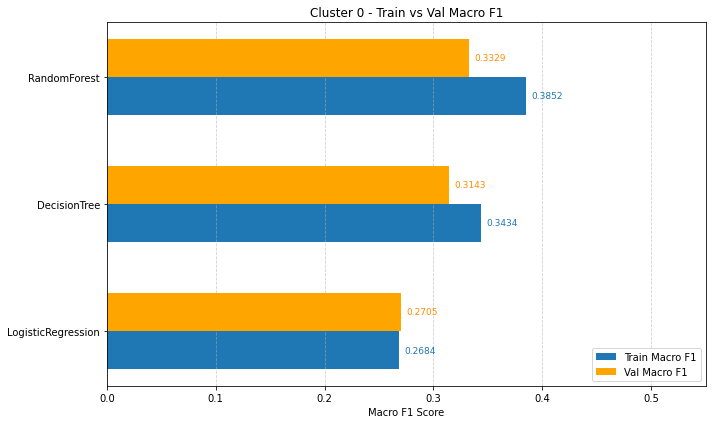

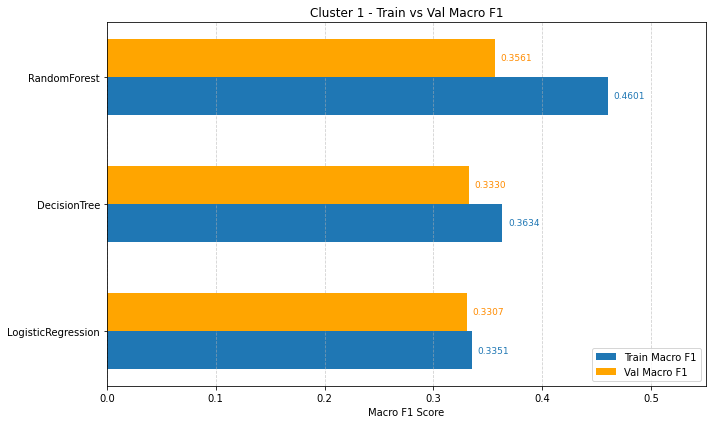

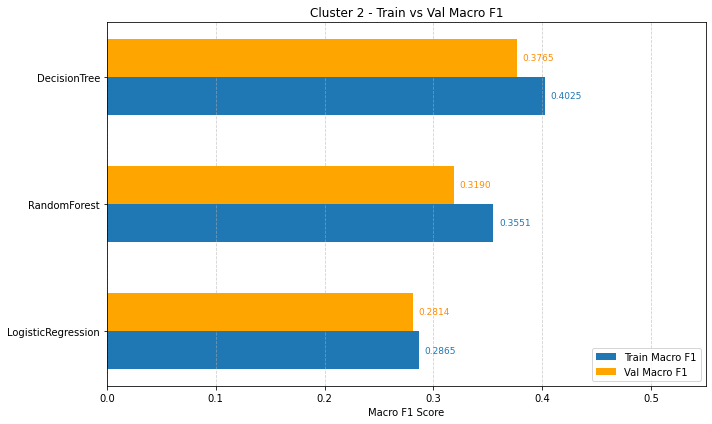

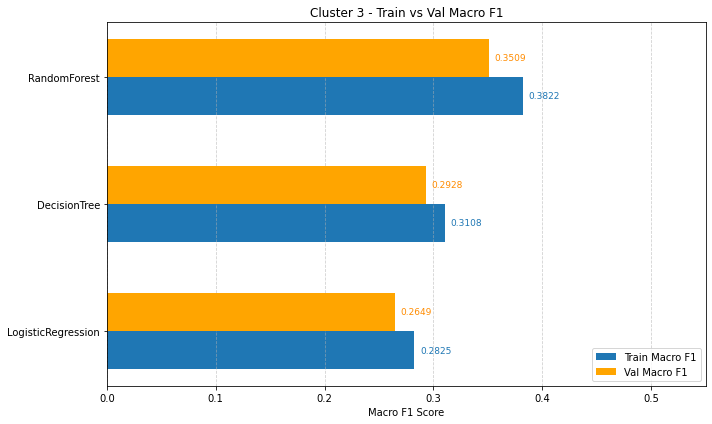

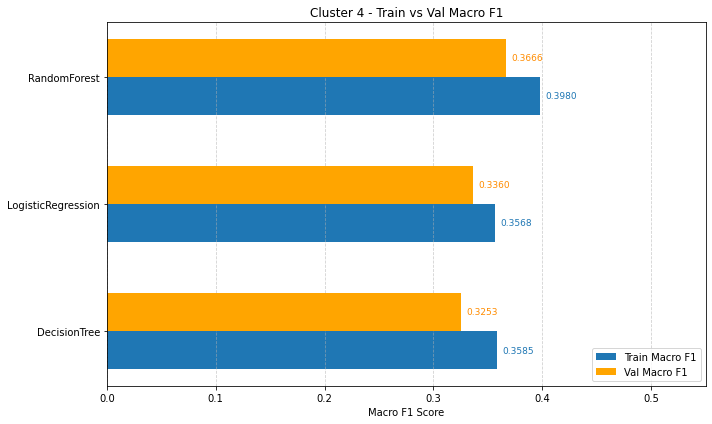

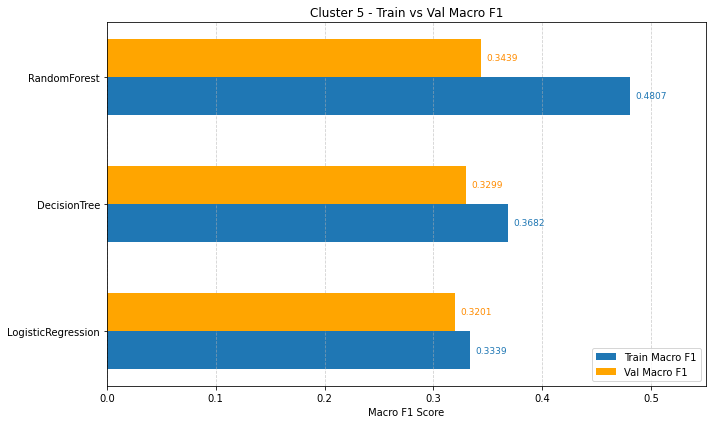

In [0]:
# Convert Spark DataFrame to Pandas
default_results_df_pd = default_results_df.toPandas()

# Plot for each cluster
for cluster_id in sorted(default_results_df_pd["cluster_id"].unique()):
    cluster_data = default_results_df_pd[default_results_df_pd["cluster_id"] == cluster_id].sort_values(by="val_macro_f1", ascending=True)

    models = cluster_data["model"]
    train_scores = cluster_data["train_macro_f1"]
    val_scores = cluster_data["val_macro_f1"]
    y_pos = range(len(models))

    plt.figure(figsize=(10, 6))

    # Train bars
    bars_train = plt.barh(
        [y - 0.15 for y in y_pos], train_scores,
        color='C0', label="Train Macro F1", height=0.3, zorder=1
    )

    # Val bars
    bars_val = plt.barh(
        [y + 0.15 for y in y_pos], val_scores,
        color='orange', label="Val Macro F1", height=0.3, zorder=2
    )

    # Add values to the bars
    for i, y in enumerate(y_pos):
        plt.text(train_scores.iloc[i] + 0.005, y - 0.15, f"{train_scores.iloc[i]:.4f}",
                 va='center', ha='left', fontsize=9, color='C0')
        plt.text(val_scores.iloc[i] + 0.005, y + 0.15, f"{val_scores.iloc[i]:.4f}",
                 va='center', ha='left', fontsize=9, color='darkorange')

    plt.yticks(y_pos, models)
    plt.xlabel("Macro F1 Score")
    plt.title(f"Cluster {cluster_id} - Train vs Val Macro F1")
    plt.legend(loc='lower right')
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.xlim(0, 0.55)
    plt.tight_layout()
    plt.show()

# 5.13 Hyperparameter Tuning

## 5.13.1 Train and Predict

In [0]:
import random
import mlflow
import mlflow.spark
from pyspark.ml.feature import VectorAssembler, IndexToString
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import Row

# Define models with param spaces for random search
model_param_spaces = {
    "RandomForest": {
        "model_class": RandomForestClassifier,
        "param_distributions": {
            "numTrees": lambda: random.randint(20, 150),
            "maxDepth": lambda: random.randint(3, 20),
            "maxBins": lambda: random.choice([32, 64, 128, 256]) # maxBins must be one of a small set of valid powers of 2 for performance and compatibility

        }
    },
    "DecisionTree": {
        "model_class": DecisionTreeClassifier,
        "param_distributions": {
            "maxDepth": lambda: random.randint(3, 20),
            "maxBins": lambda: random.choice([32, 64, 128, 256]), # maxBins must be one of a small set of valid powers of 2 for performance and compatibility
            "minInstancesPerNode": lambda: random.randint(1, 5)
        }
    }
}

In [0]:
# Set MLflow experiment
mlflow.set_experiment("/Users/marcogalao@outlook.pt/TunedModels")

# Evaluators
evaluator_f1 = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction", metricName="f1")
evaluator_acc = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction", metricName="accuracy")

# Number of random search trials per model per cluster
n_trials = 1

results = []

for cluster_id in [5]:
    print(f"\n--- Cluster {cluster_id} ---")
    train_df = train_dfs_by_cluster[cluster_id]
    val_df = val_dfs_by_cluster[cluster_id]
    features = majority_voted_features_by_cluster[cluster_id]

    # Prepare data (feature vector)
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    train_prepared = assembler.transform(train_df)
    val_prepared = assembler.transform(val_df)

    # Choose model based on cluster
    if cluster_id == 2:
        model_name = "DecisionTree"
    else:
        model_name = "RandomForest"

    model_info = model_param_spaces[model_name]
    ModelClass = model_info["model_class"]
    param_dist = model_info["param_distributions"]

    for trial in range(n_trials):
        # Sample params randomly
        params = {k: v() for k, v in param_dist.items()}

        # Create model with sampled params
        model = ModelClass(
            featuresCol="features", 
            labelCol=target_column, 
            weightCol="weight", 
            seed=42, 
            **params
        )

        with mlflow.start_run(run_name=f"Cluster{cluster_id}_{model_name}_trial{29+trial+1}"):
            print(f"\n{model_name} trial {29+trial+1} with params: {params}")
        
            # Train
            trained_model = model.fit(train_prepared)

            # Predict on train and validation
            train_pred = trained_model.transform(train_prepared)
            val_pred = trained_model.transform(val_prepared)

            # Evaluate metrics
            train_macro_f1 = compute_macro_f1(decode_predictions(train_pred))
            val_macro_f1 = compute_macro_f1(decode_predictions(val_pred))

            train_weighted_f1 = evaluator_f1.evaluate(train_pred)
            val_weighted_f1 = evaluator_f1.evaluate(val_pred)
            
            train_accuracy = evaluator_acc.evaluate(train_pred)
            val_accuracy = evaluator_acc.evaluate(val_pred)                

            # Log metrics to MLflow
            mlflow.log_params(params)
            mlflow.log_metrics({
                "train_macro_f1": train_macro_f1,
                "val_macro_f1": val_macro_f1,
                "overfitting_macro_f1": train_macro_f1 - val_macro_f1,
                "train_weighted_f1": train_weighted_f1,
                "val_weighted_f1": val_weighted_f1,
                "train_accuracy": train_accuracy,
                "val_accuracy": val_accuracy,
            })
            mlflow.set_tag("cluster_id", cluster_id)
            mlflow.set_tag("model", model_name)
            mlflow.set_tag("trial", 29+trial+1)

            # Log model artifact
            mlflow.spark.log_model(trained_model, artifact_path="model")

            # Save for summary
            results.append({
                "cluster_id": cluster_id,
                "model": model_name,
                **params,
                "train_macro_f1": train_macro_f1,
                "val_macro_f1": val_macro_f1,
                "overfitting_macro_f1": train_macro_f1 - val_macro_f1,
                "train_weighted_f1": train_weighted_f1,
                "val_weighted_f1": val_weighted_f1,
                "train_accuracy": train_accuracy,
                "val_accuracy": val_accuracy,
                "trial": 29+trial+1
            })


--- Cluster 5 ---
RandomForest trial 30 with params: {'numTrees': 132, 'maxDepth': 13, 'maxBins': 64}


2025/06/07 12:00:48 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2025/06/07 12:02:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/2875843347986715/053a011b7b7a411b87e0dbc96f29f487/artifacts/model/sparkml, flavor: spark), fall back to return ['pyspark==3.3.2']. Set logging level to DEBUG to see the full traceback.
/databricks/python/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## 5.13.2 Identify Best Models

In [0]:
from mlflow.tracking import MlflowClient

# Load the MLflow experiment
client = MlflowClient()
experiment = client.get_experiment_by_name("/Users/marcogalao@outlook.pt/TunedModels")
experiment_id = experiment.experiment_id

# Fetch all runs
runs = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string="",
    run_view_type=1
)

# Convert to DataFrame
runs_df = pd.DataFrame([{
    **r.data.metrics,
    **r.data.params,
    **r.data.tags,
    "run_id": r.info.run_id,
} for r in runs])

print(f"Total number of runs: {len(runs_df)}")

Total number of runs: 180


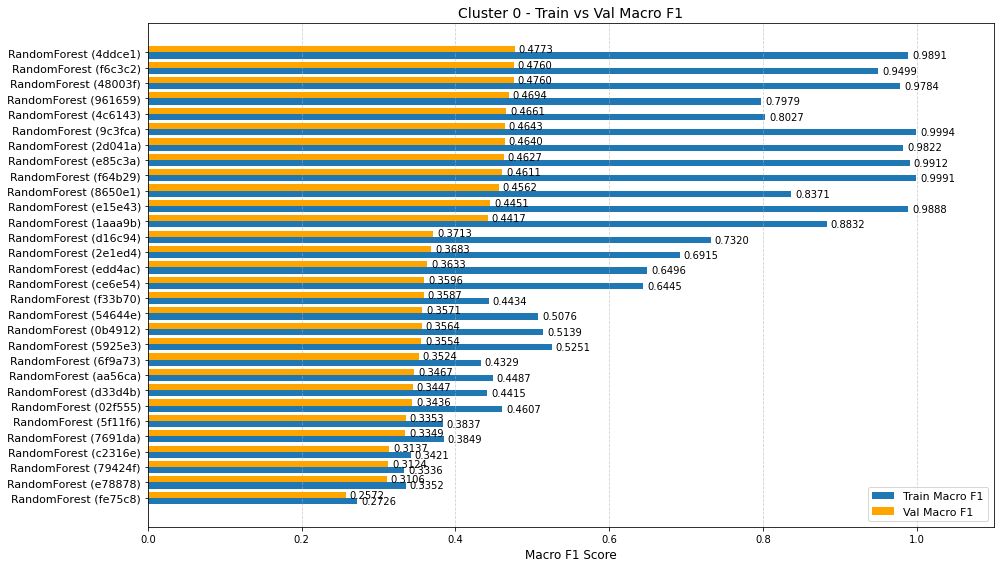

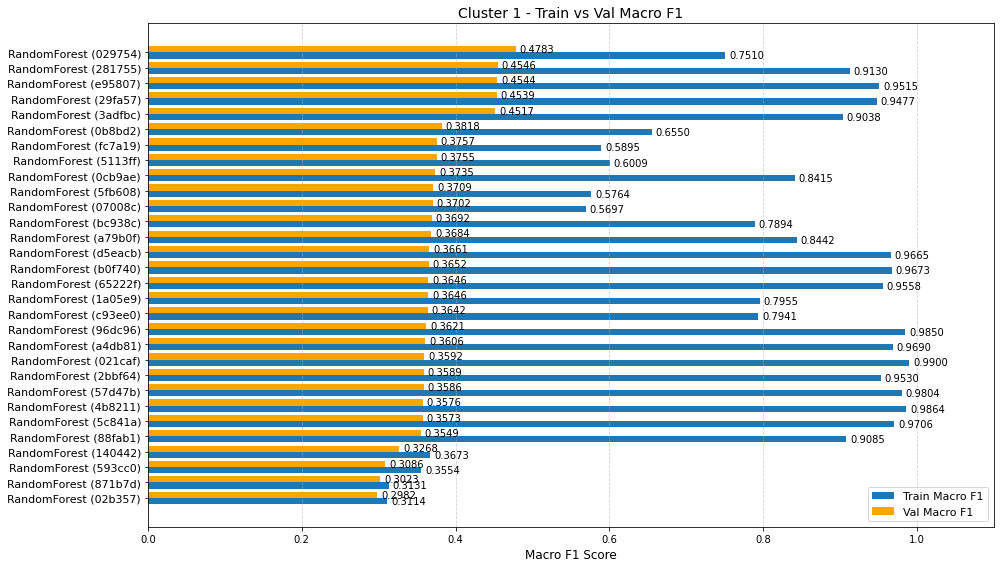

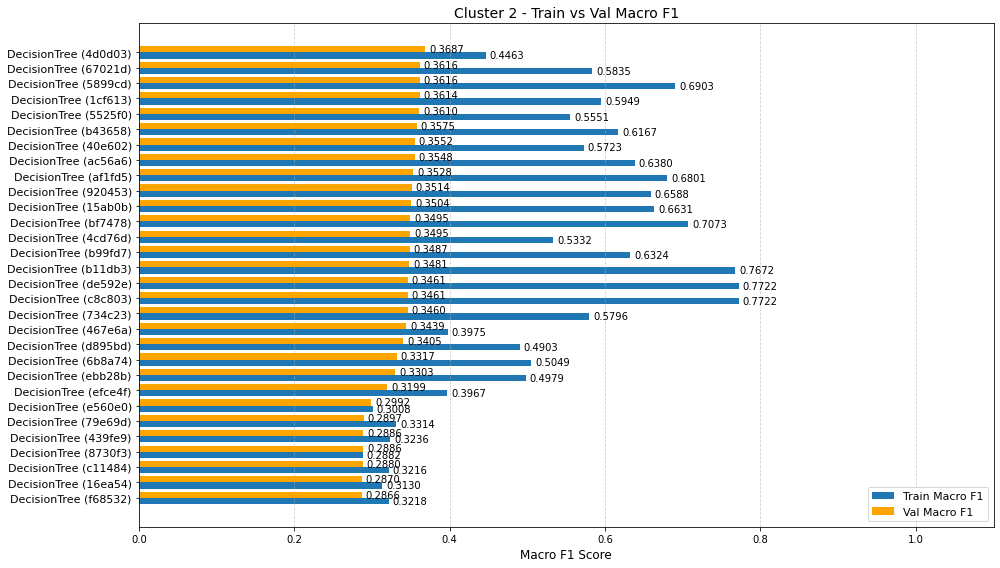

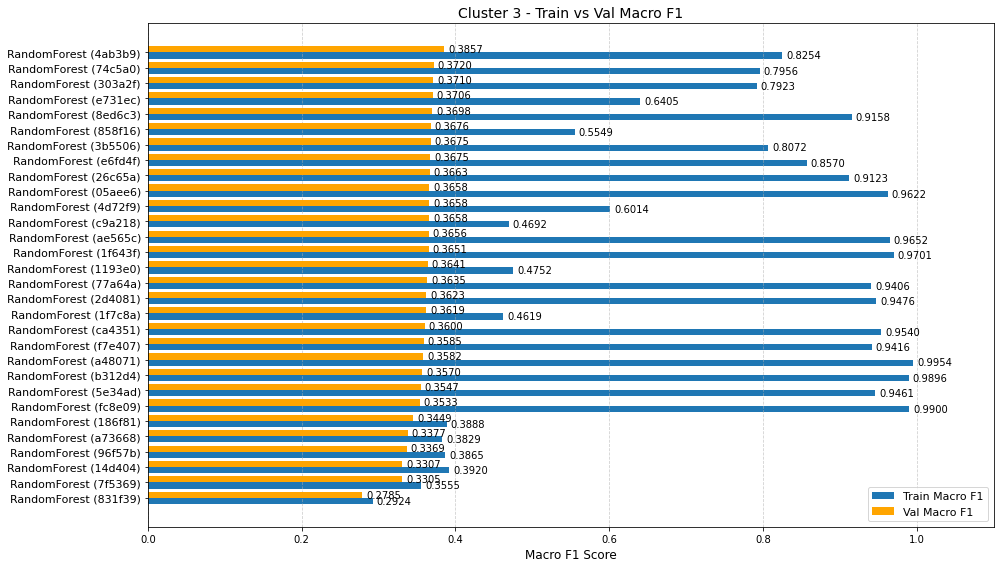

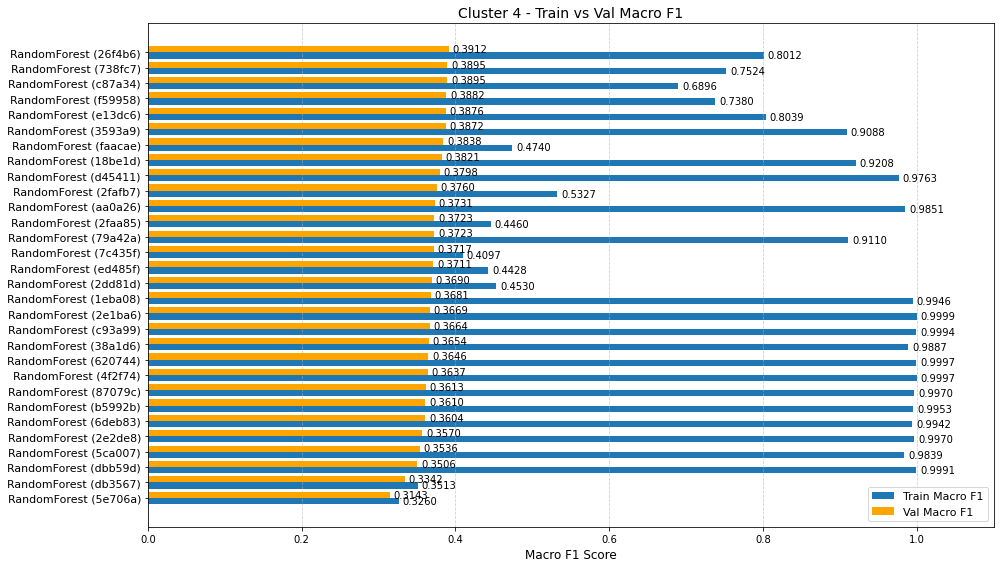

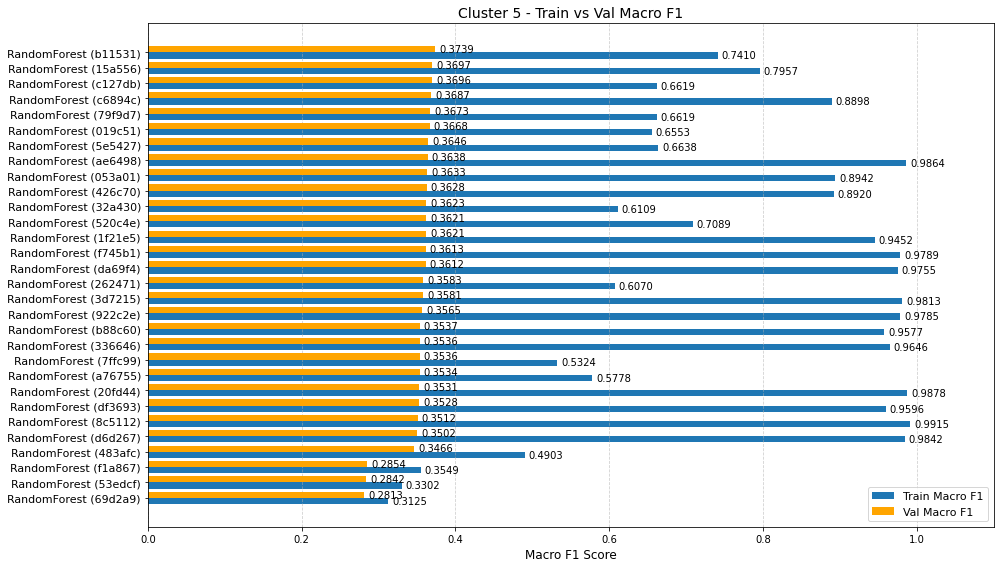

In [0]:
# Convert numeric columns
for col in ["train_macro_f1", "val_macro_f1"]:
    runs_df[col] = pd.to_numeric(runs_df[col], errors="coerce")

# Sort for consistency
runs_df = runs_df.sort_values(by=["cluster_id", "val_macro_f1"])

# Plot for each cluster
for cluster_id in sorted(runs_df["cluster_id"].unique(), key=lambda x: int(x)):
    cluster_data = runs_df[runs_df["cluster_id"] == cluster_id]

    # Store model names and ids
    models = [f"{m} ({rid[:6]})" for m, rid in zip(cluster_data["model"], cluster_data["run_id"])]

    train_scores = cluster_data["train_macro_f1"]
    val_scores = cluster_data["val_macro_f1"]
    y_pos = range(len(models))

    # Figure size
    plt.figure(figsize=(14, 8))

    # Train bars
    bars_train = plt.barh(
        [y - 0.2 for y in y_pos], train_scores,
        color='C0', label="Train Macro F1", height=0.4, zorder=1
    )

    # Val bars
    bars_val = plt.barh(
        [y + 0.2 for y in y_pos], val_scores,
        color='orange', label="Val Macro F1", height=0.4, zorder=2
    )

    # Add values
    for i, y in enumerate(y_pos):
        if pd.notna(train_scores.iloc[i]):
            plt.text(train_scores.iloc[i] + 0.005, y - 0.2, f"{train_scores.iloc[i]:.4f}",
                     va='center', ha='left', fontsize=10)
        if pd.notna(val_scores.iloc[i]):
            plt.text(val_scores.iloc[i] + 0.005, y + 0.2, f"{val_scores.iloc[i]:.4f}",
                     va='center', ha='left', fontsize=10)

    plt.yticks(y_pos, models, fontsize=11)
    plt.xlabel("Macro F1 Score", fontsize=12)
    plt.title(f"Cluster {cluster_id} - Train vs Val Macro F1", fontsize=14)
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.xlim(0, 1.1)
    plt.tight_layout()
    plt.show()

In [0]:
# Best models (based on the previous plots)
best_runs = {
    "0": "5f11f6",
    "1": "140442",
    "2": "467e6a",
    "3": "186f81",
    "4": "7c435f",
    "5": "69d2a9",
}

In [0]:
from mlflow.entities import ViewType

# Set new experiment
mlflow.set_experiment("/Users/marcogalao@outlook.pt/FinalModels")

client = MlflowClient()

# Get the experiment where best runs were logged
tuned_experiment = client.get_experiment_by_name("/Users/marcogalao@outlook.pt/TunedModels")
tuned_experiment_id = tuned_experiment.experiment_id

for cluster_id, partial_run_id in best_runs.items():
    cluster_id = int(cluster_id)
    print(f"\nModel of Cluster {cluster_id} from run ID {partial_run_id}...")

    # Find full run ID by searching runs only within the tuned experiment
    full_run_id = None
    runs = client.search_runs(experiment_ids=[tuned_experiment_id], filter_string="", run_view_type=ViewType.ALL)

    for run in runs:
        if run.info.run_id.startswith(partial_run_id):
            full_run_id = run.info.run_id
            break

    if full_run_id is None:
        print(f"Run with ID ending {partial_run_id} not found in experiment {tuned_experiment_id}!")
        continue

    # Get model name and parameters
    model_name = run.data.tags.get("model", "UnknownModel")
    params = run.data.params

    print(f"Model name: {model_name}")
    print("Parameters:")
    for param_name, param_value in params.items():
        print(f"  - {param_name}: {param_value}")


Model of Cluster 0 from run ID 5f11f6...
Model name: RandomForest
Parameters:
  - numTrees: 57
  - maxDepth: 5
  - maxBins: 256

Model of Cluster 1 from run ID 140442...
Model name: RandomForest
Parameters:
  - maxBins: 256
  - maxDepth: 4
  - numTrees: 102

Model of Cluster 2 from run ID 467e6a...
Model name: DecisionTree
Parameters:
  - maxBins: 64
  - maxDepth: 8
  - minInstancesPerNode: 4

Model of Cluster 3 from run ID 186f81...
Model name: RandomForest
Parameters:
  - maxBins: 64
  - maxDepth: 5
  - numTrees: 139

Model of Cluster 4 from run ID 7c435f...
Model name: RandomForest
Parameters:
  - maxBins: 32
  - maxDepth: 5
  - numTrees: 127

Model of Cluster 5 from run ID 69d2a9...
Model name: RandomForest
Parameters:
  - maxBins: 128
  - maxDepth: 3
  - numTrees: 23


# 5.14 Final Train, Predict, Evaluate

## 5.14.1 Model Without weightCol Parameter (Controls Imbalance)

In [0]:
import mlflow
import mlflow.spark
from mlflow.tracking import MlflowClient
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from mlflow.entities import ViewType

# Set new experiment
mlflow.set_experiment("/Users/marcogalao@outlook.pt/FinalModels")

client = MlflowClient()

# Evaluators
evaluator_f1 = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction", metricName="f1")
evaluator_acc = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction", metricName="accuracy")

# To store results and final models
results_no_weightcol = []
final_models_no_weightcol_by_cluster = {}
test_decoded_predictions_no_weightcol = {}  

# Get the experiment where best runs were logged
tuned_experiment = client.get_experiment_by_name("/Users/marcogalao@outlook.pt/TunedModels")
tuned_experiment_id = tuned_experiment.experiment_id

for cluster_id, partial_run_id in best_runs.items():
    cluster_id = int(cluster_id)
    print(f"\nRetraining model (without WeightCol) for cluster {cluster_id} from run ID {partial_run_id}...")

    # Find full run ID by searching runs only within the tuned experiment
    full_run_id = None
    runs = client.search_runs(experiment_ids=[tuned_experiment_id], filter_string="", run_view_type=ViewType.ALL)

    for run in runs:
        if run.info.run_id.startswith(partial_run_id):
            full_run_id = run.info.run_id
            break

    if full_run_id is None:
        print(f"Run with ID ending {partial_run_id} not found in experiment {tuned_experiment_id}!")
        continue

    run = client.get_run(full_run_id)
    params = run.data.params
    model_name = run.data.tags["model"]

    # Get train and test df
    train_df = train_dfs_by_cluster[cluster_id]
    test_df = test_dfs_by_cluster[cluster_id]

    # Assemble features
    features = majority_voted_features_by_cluster[cluster_id]
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    full_train_prepared = assembler.transform(train_df)
    test_prepared = assembler.transform(test_df)

    # Convert params
    def cast_param_value(v):
        try:
            return int(v)
        except ValueError:
            try:
                return float(v)
            except ValueError:
                return v

    typed_params = {k: cast_param_value(v) for k, v in params.items()}

    # Model class
    if model_name == "RandomForest":
        ModelClass = RandomForestClassifier
    elif model_name == "DecisionTree":
        ModelClass = DecisionTreeClassifier
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    model = ModelClass(
        featuresCol="features",
        labelCol=target_column,
        # weightCol="weight",
        seed=42,
        **typed_params
    )

    # Train and predict
    trained_model = model.fit(full_train_prepared)
    test_pred = trained_model.transform(test_prepared)

    # Decode predictions
    test_decoded = decode_predictions(test_pred)
    test_decoded_predictions_no_weightcol[cluster_id] = test_decoded

    # Evaluate
    macro_f1 = compute_macro_f1(test_decoded)
    weighted_f1 = evaluator_f1.evaluate(test_pred)
    accuracy = evaluator_acc.evaluate(test_pred)

    # Append results
    results_no_weightcol.append({
        "cluster_id": cluster_id,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "accuracy": accuracy,
        "model": model_name
    })

    print(f"Cluster {cluster_id} - Macro F1: {macro_f1:.4f}, Weighted F1: {weighted_f1:.4f}, Accuracy: {accuracy:.4f}")

    # Log
    with mlflow.start_run(run_name=f"FinalModel_No_WeightCol_Cluster{cluster_id}"):
        mlflow.set_tag("stage", "final")
        mlflow.set_tag("cluster_id", cluster_id)
        mlflow.set_tag("model", model_name)
        mlflow.log_params(typed_params)
        mlflow.log_metrics({
            "test_macro_f1": macro_f1,
            "test_weighted_f1": weighted_f1,
            "test_accuracy": accuracy
        })
        mlflow.spark.log_model(trained_model, artifact_path="model")

    final_models_no_weightcol_by_cluster[cluster_id] = trained_model


Retraining model (without WeightCol) for cluster 0 from run ID 5f11f6...
Cluster 0 - Macro F1: 0.3784, Weighted F1: 0.7619, Accuracy: 0.7914


2025/06/07 15:27:46 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().



Retraining model (without WeightCol) for cluster 1 from run ID 140442...
Cluster 1 - Macro F1: 0.3252, Weighted F1: 0.5595, Accuracy: 0.6436


2025/06/07 15:30:52 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().



Retraining model (without WeightCol) for cluster 2 from run ID 467e6a...
Cluster 2 - Macro F1: 0.3710, Weighted F1: 0.6006, Accuracy: 0.6053


2025/06/07 15:33:54 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().



Retraining model (without WeightCol) for cluster 3 from run ID 186f81...
Cluster 3 - Macro F1: 0.3398, Weighted F1: 0.5628, Accuracy: 0.6014


2025/06/07 15:37:11 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().



Retraining model (without WeightCol) for cluster 4 from run ID 7c435f...
Cluster 4 - Macro F1: 0.3527, Weighted F1: 0.5756, Accuracy: 0.5916


2025/06/07 15:40:30 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().



Retraining model (without WeightCol) for cluster 5 from run ID 69d2a9...
Cluster 5 - Macro F1: 0.2872, Weighted F1: 0.5050, Accuracy: 0.6013


2025/06/07 15:43:07 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


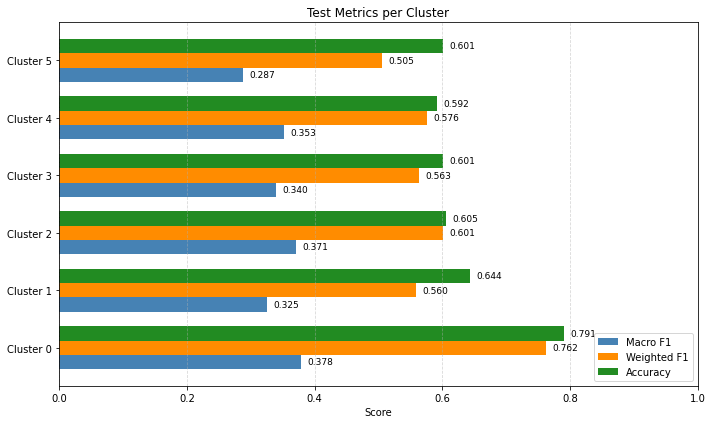

In [0]:
# Convert to DataFrame
results_df = pd.DataFrame(results_no_weightcol).sort_values("cluster_id")

# Plotting
clusters = results_df["cluster_id"]
macro_f1 = results_df["macro_f1"]
weighted_f1 = results_df["weighted_f1"]
accuracy = results_df["accuracy"]
y_pos = range(len(clusters))

plt.figure(figsize=(10, 6))

# Bar plots
bar_width = 0.25
plt.barh([y - bar_width for y in y_pos], macro_f1, height=bar_width, color='steelblue', label='Macro F1')
plt.barh(y_pos, weighted_f1, height=bar_width, color='darkorange', label='Weighted F1')
plt.barh([y + bar_width for y in y_pos], accuracy, height=bar_width, color='forestgreen', label='Accuracy')

# Labels
for i, y in enumerate(y_pos):
    plt.text(macro_f1.iloc[i] + 0.01, y - bar_width, f"{macro_f1.iloc[i]:.3f}", va='center', fontsize=9)
    plt.text(weighted_f1.iloc[i] + 0.01, y, f"{weighted_f1.iloc[i]:.3f}", va='center', fontsize=9)
    plt.text(accuracy.iloc[i] + 0.01, y + bar_width, f"{accuracy.iloc[i]:.3f}", va='center', fontsize=9)

# Y-axis with cluster labels
plt.yticks(y_pos, [f"Cluster {cid}" for cid in clusters])
plt.xlabel("Score")
plt.title("Test Metrics per Cluster")
plt.legend(loc="lower right")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()


Confusion Matrix (Test Set) - Cluster 0


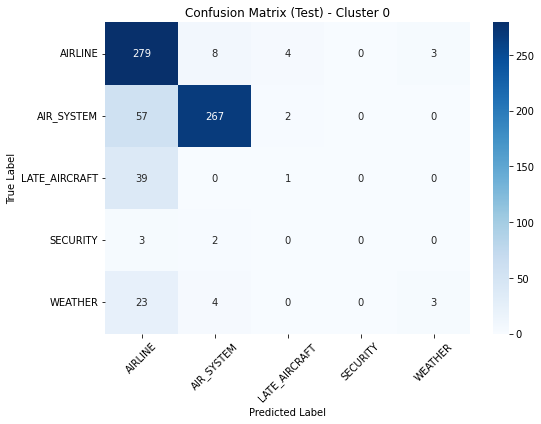


Confusion Matrix (Test Set) - Cluster 1
<Figure size 432x288 with 0 Axes>

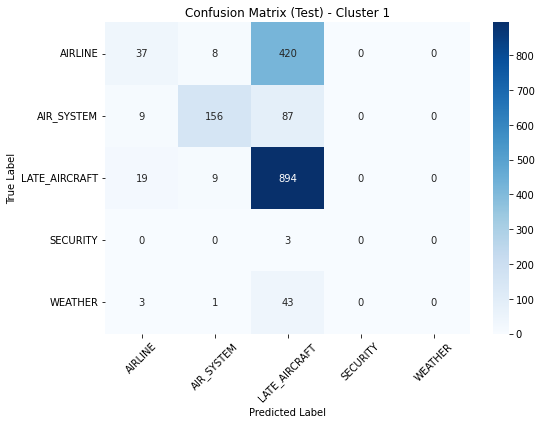


Confusion Matrix (Test Set) - Cluster 2
<Figure size 432x288 with 0 Axes>

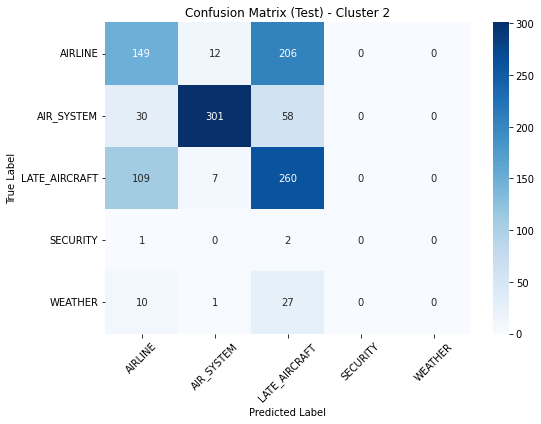


Confusion Matrix (Test Set) - Cluster 3
<Figure size 432x288 with 0 Axes>

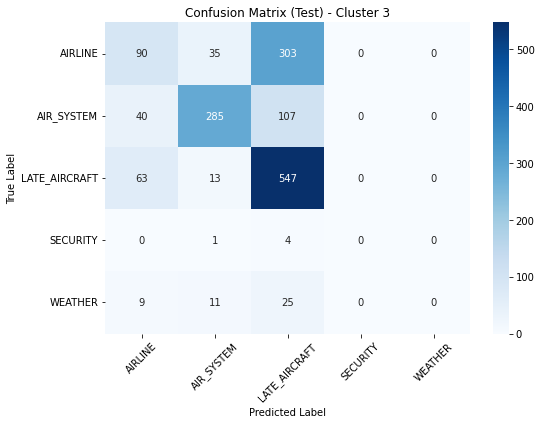


Confusion Matrix (Test Set) - Cluster 4
<Figure size 432x288 with 0 Axes>

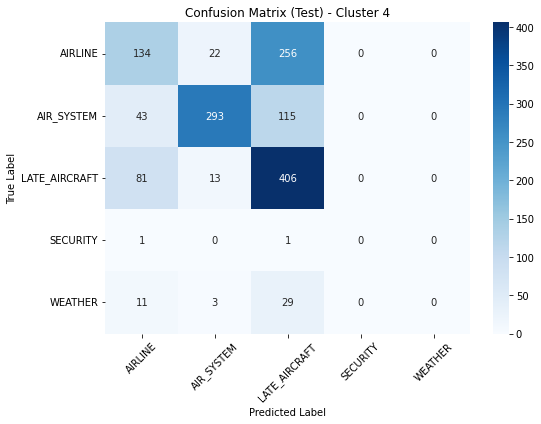


Confusion Matrix (Test Set) - Cluster 5
<Figure size 432x288 with 0 Axes>

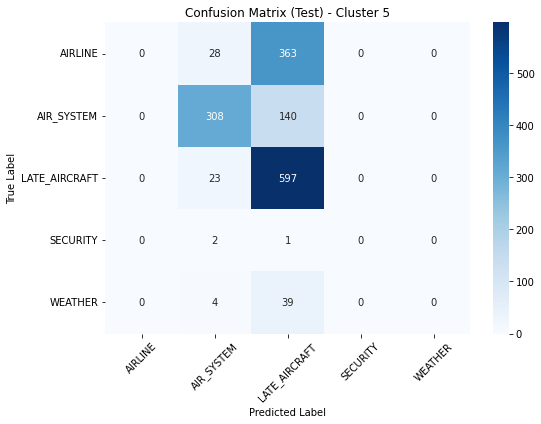

<Figure size 432x288 with 0 Axes>

In [0]:
def plot_final_confusion_matrices(test_decoded_predictions, all_labels=None):
    for cluster_id in sorted(test_decoded_predictions.keys()):
        print(f"\nConfusion Matrix (Test Set) - Cluster {cluster_id}")

        df = test_decoded_predictions[cluster_id]

        # Create confusion matrix dataframe
        confusion_df = df.groupBy("true_label", "predicted_label").count()
        confusion_pd = confusion_df.toPandas().pivot(
            index="true_label",
            columns="predicted_label",
            values="count"
        )

        # Get full label list
        if all_labels is None:
            labels = sorted(set(confusion_pd.index).union(set(confusion_pd.columns)))
        else:
            labels = sorted(all_labels)

        # Reindex both axes and fill missing with 0s
        confusion_pd = confusion_pd.reindex(index=labels, columns=labels)
        confusion_pd = confusion_pd.fillna(0).astype(int)

        # Plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_pd, annot=True, fmt="d", cmap="Blues", cbar=True)
        plt.title(f"Confusion Matrix (Test) - Cluster {cluster_id}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        plt.clf()

all_labels = sorted([
    row["PRIMARY_DELAY_CAUSE"]
    for row in train_df.select("PRIMARY_DELAY_CAUSE").distinct().collect()
])
plot_final_confusion_matrices(test_decoded_predictions_no_weightcol, all_labels)

## 5.14.2 Model With weightCol Parameter (Controls Imbalance)

In [0]:
import mlflow
import mlflow.spark
from mlflow.tracking import MlflowClient
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from mlflow.entities import ViewType

# Set new experiment
mlflow.set_experiment("/Users/marcogalao@outlook.pt/FinalModels")

client = MlflowClient()

# Evaluators
evaluator_f1 = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction", metricName="f1")
evaluator_acc = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction", metricName="accuracy")

# To store results and final models
results = []
final_models_by_cluster = {}
test_decoded_predictions = {}  

# Get the experiment where best runs were logged
tuned_experiment = client.get_experiment_by_name("/Users/marcogalao@outlook.pt/TunedModels")
tuned_experiment_id = tuned_experiment.experiment_id

for cluster_id, partial_run_id in best_runs.items():
    cluster_id = int(cluster_id)
    print(f"\nRetraining model for cluster {cluster_id} from run ID {partial_run_id}...")

    # Find full run ID by searching runs only within the tuned experiment
    full_run_id = None
    runs = client.search_runs(experiment_ids=[tuned_experiment_id], filter_string="", run_view_type=ViewType.ALL)

    for run in runs:
        if run.info.run_id.startswith(partial_run_id):
            full_run_id = run.info.run_id
            break

    if full_run_id is None:
        print(f"Run with ID ending {partial_run_id} not found in experiment {tuned_experiment_id}!")
        continue

    run = client.get_run(full_run_id)
    params = run.data.params
    model_name = run.data.tags["model"]

    # Get train and test df
    train_df = train_dfs_by_cluster[cluster_id]
    test_df = test_dfs_by_cluster[cluster_id]

    # Assemble features
    features = majority_voted_features_by_cluster[cluster_id]
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    full_train_prepared = assembler.transform(train_df)
    test_prepared = assembler.transform(test_df)

    # Convert params
    def cast_param_value(v):
        try:
            return int(v)
        except ValueError:
            try:
                return float(v)
            except ValueError:
                return v

    typed_params = {k: cast_param_value(v) for k, v in params.items()}

    # Model class
    if model_name == "RandomForest":
        ModelClass = RandomForestClassifier
    elif model_name == "DecisionTree":
        ModelClass = DecisionTreeClassifier
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    model = ModelClass(
        featuresCol="features",
        labelCol=target_column,
        weightCol="weight",
        seed=42,
        **typed_params
    )

    # Train and predict
    trained_model = model.fit(full_train_prepared)
    test_pred = trained_model.transform(test_prepared)

    # Decode predictions
    test_decoded = decode_predictions(test_pred)
    test_decoded_predictions[cluster_id] = test_decoded

    # Evaluate
    macro_f1 = compute_macro_f1(test_decoded)
    weighted_f1 = evaluator_f1.evaluate(test_pred)
    accuracy = evaluator_acc.evaluate(test_pred)

    # Append results
    results.append({
        "cluster_id": cluster_id,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "accuracy": accuracy,
        "model": model_name
    })

    print(f"Cluster {cluster_id} - Macro F1: {macro_f1:.4f}, Weighted F1: {weighted_f1:.4f}, Accuracy: {accuracy:.4f}")

    # Log
    with mlflow.start_run(run_name=f"FinalModel_Cluster{cluster_id}"):
        mlflow.set_tag("stage", "final")
        mlflow.set_tag("cluster_id", cluster_id)
        mlflow.set_tag("model", model_name)
        mlflow.log_params(typed_params)
        mlflow.log_metrics({
            "test_macro_f1": macro_f1,
            "test_weighted_f1": weighted_f1,
            "test_accuracy": accuracy
        })
        mlflow.spark.log_model(trained_model, artifact_path="model")

    final_models_by_cluster[cluster_id] = trained_model


Retraining model for cluster 0 from run ID 5f11f6...
Cluster 0 - Macro F1: 0.3535, Weighted F1: 0.6796, Accuracy: 0.6388


2025/06/07 15:03:56 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().



Retraining model for cluster 1 from run ID 140442...
Cluster 1 - Macro F1: 0.3227, Weighted F1: 0.5592, Accuracy: 0.6353


2025/06/07 15:06:48 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().



Retraining model for cluster 2 from run ID 467e6a...
Cluster 2 - Macro F1: 0.3407, Weighted F1: 0.5255, Accuracy: 0.4697


2025/06/07 15:09:30 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().



Retraining model for cluster 3 from run ID 186f81...
Cluster 3 - Macro F1: 0.3650, Weighted F1: 0.5519, Accuracy: 0.5342


2025/06/07 15:12:32 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().



Retraining model for cluster 4 from run ID 7c435f...
Cluster 4 - Macro F1: 0.3610, Weighted F1: 0.5498, Accuracy: 0.5036


2025/06/07 15:15:43 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().



Retraining model for cluster 5 from run ID 69d2a9...
Cluster 5 - Macro F1: 0.3155, Weighted F1: 0.4751, Accuracy: 0.4704


2025/06/07 15:18:41 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


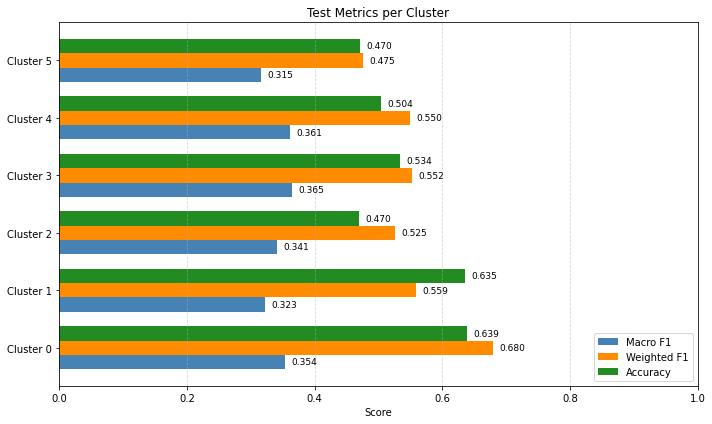

In [0]:
# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values("cluster_id")

# Plotting
clusters = results_df["cluster_id"]
macro_f1 = results_df["macro_f1"]
weighted_f1 = results_df["weighted_f1"]
accuracy = results_df["accuracy"]
y_pos = range(len(clusters))

plt.figure(figsize=(10, 6))

# Bar plots
bar_width = 0.25
plt.barh([y - bar_width for y in y_pos], macro_f1, height=bar_width, color='steelblue', label='Macro F1')
plt.barh(y_pos, weighted_f1, height=bar_width, color='darkorange', label='Weighted F1')
plt.barh([y + bar_width for y in y_pos], accuracy, height=bar_width, color='forestgreen', label='Accuracy')

# Labels
for i, y in enumerate(y_pos):
    plt.text(macro_f1.iloc[i] + 0.01, y - bar_width, f"{macro_f1.iloc[i]:.3f}", va='center', fontsize=9)
    plt.text(weighted_f1.iloc[i] + 0.01, y, f"{weighted_f1.iloc[i]:.3f}", va='center', fontsize=9)
    plt.text(accuracy.iloc[i] + 0.01, y + bar_width, f"{accuracy.iloc[i]:.3f}", va='center', fontsize=9)

# Y-axis with cluster labels
plt.yticks(y_pos, [f"Cluster {cid}" for cid in clusters])
plt.xlabel("Score")
plt.title("Test Metrics per Cluster")
plt.legend(loc="lower right")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()


Confusion Matrix (Test Set) - Cluster 0


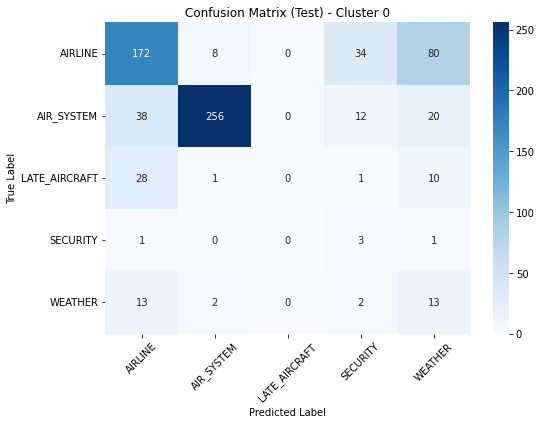


Confusion Matrix (Test Set) - Cluster 1
<Figure size 432x288 with 0 Axes>

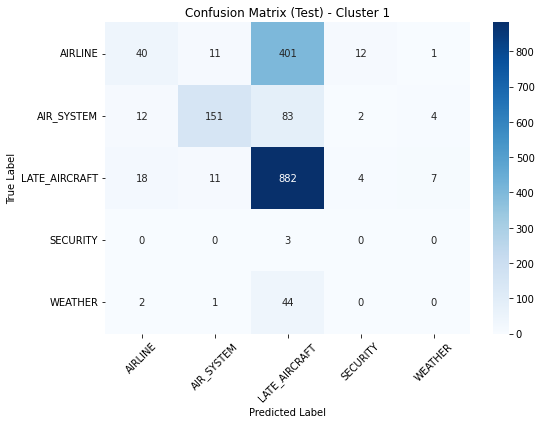


Confusion Matrix (Test Set) - Cluster 2
<Figure size 432x288 with 0 Axes>

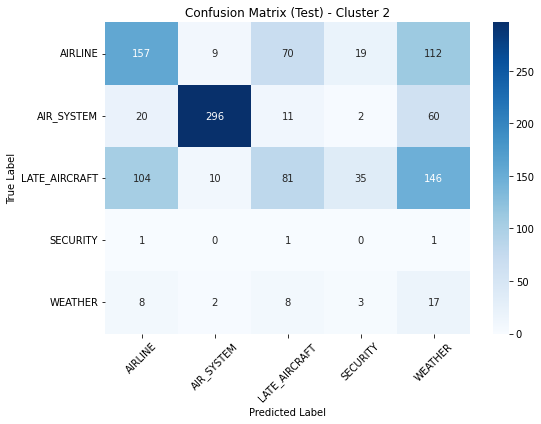


Confusion Matrix (Test Set) - Cluster 3
<Figure size 432x288 with 0 Axes>

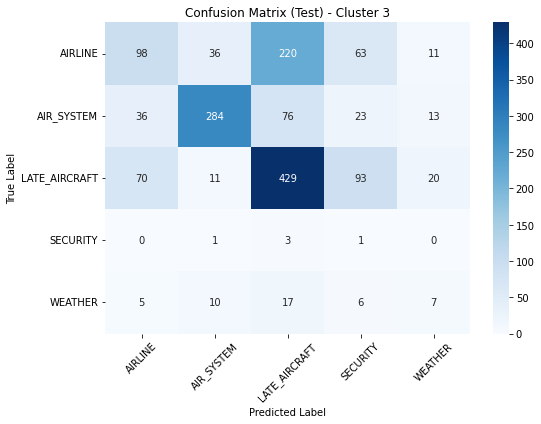


Confusion Matrix (Test Set) - Cluster 4
<Figure size 432x288 with 0 Axes>

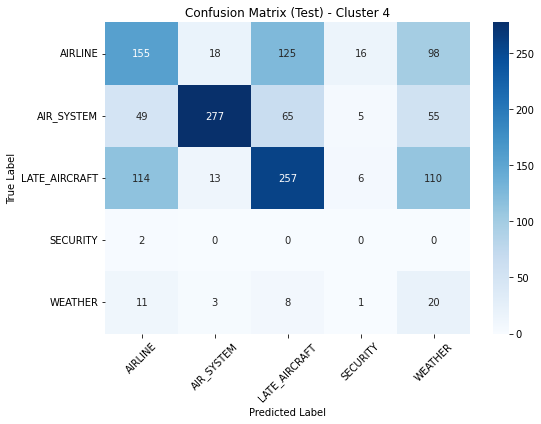


Confusion Matrix (Test Set) - Cluster 5
<Figure size 432x288 with 0 Axes>

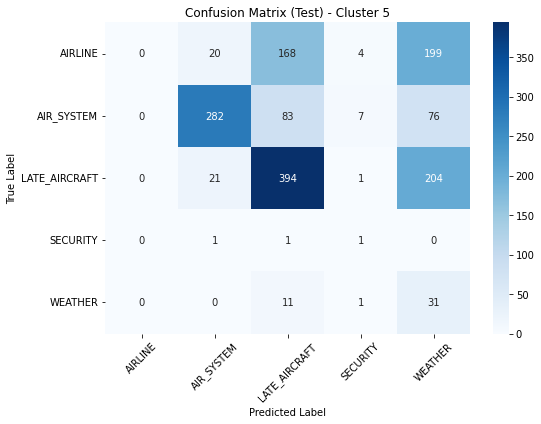

<Figure size 432x288 with 0 Axes>

In [0]:
def plot_final_confusion_matrices(test_decoded_predictions, all_labels=None):
    for cluster_id in sorted(test_decoded_predictions.keys()):
        print(f"\nConfusion Matrix (Test Set) - Cluster {cluster_id}")

        df = test_decoded_predictions[cluster_id]

        # Create confusion matrix dataframe
        confusion_df = df.groupBy("true_label", "predicted_label").count()
        confusion_pd = confusion_df.toPandas().pivot(
            index="true_label",
            columns="predicted_label",
            values="count"
        )

        # Get full label list
        if all_labels is None:
            labels = sorted(set(confusion_pd.index).union(set(confusion_pd.columns)))
        else:
            labels = sorted(all_labels)

        # Reindex both axes and fill missing with 0s
        confusion_pd = confusion_pd.reindex(index=labels, columns=labels)
        confusion_pd = confusion_pd.fillna(0).astype(int)

        # Plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_pd, annot=True, fmt="d", cmap="Blues", cbar=True)
        plt.title(f"Confusion Matrix (Test) - Cluster {cluster_id}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        plt.clf()

all_labels = sorted([
    row["PRIMARY_DELAY_CAUSE"]
    for row in train_df.select("PRIMARY_DELAY_CAUSE").distinct().collect()
])
plot_final_confusion_matrices(test_decoded_predictions, all_labels)

# 5.15 Export Test Predictions

In [0]:
for cluster_id, df in test_decoded_predictions.items():
    df.write.mode("overwrite") \
      .option("overwriteSchema", "true") \
      .format("delta") \
      .save(f"/dbfs/FileStore/tables/test_predictions_cluster_{cluster_id}")

In [0]:
test_decoded_predictions[0].limit(10).display()

index ROUTE DESTINATION_AIRPORT ORIGIN_AIRPORT AIRLINE DAY_OF_WEEK DEPARTURE_DELAY TAXI_OUT SCHEDULED_TIME DISTANCE SEASON SCHEDULED_DEPARTURE_PERIOD IS_WEEKEND DELAYED_DEPARTURE_FLAG SCHEDULED_DEPARTURE_min SCHEDULED_ARRIVAL_min DEPARTURE_TIME_min WHEELS_OFF_min ARRIVAL_TIME_min SEASON_vec SCHEDULED_DEPARTURE_PERIOD_vec FLIGHT_NUMBER_freq TAIL_NUMBER_freq AIRLINE_freq ORIGIN_AIRPORT_freq DESTINATION_AIRPORT_freq ROUTE_freq PRIMARY_DELAY_CAUSE PRIMARY_DELAY_CAUSE_index numerical_vector scaled_features cluster features rawPrediction probability prediction predicted_label true_label 1121 SNA_DFW DFW SNA AA 5.0 20.0 17.0 178.0 1205.0 Winter Early Morning 0.0 1.0 450.0 748.0 470.0 487.0 763.0 Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) 1.33E-4 3.47E-4 0.122488 0.005151 0.044175 5.61E-4 AIRLINE 1.0 Map(vectorType -> dense, length -> 18, values -> List(5.0, 20.0, 17.0, 178.0, 1205.0, 0.0, 1.0, 450.0, 748.0, 470.0, 487.0, 763.0, 1.3299999409355223E-4, 3.4699999378062785E-4, 0.12248799949884415, 0.005150999873876572, 0.04417499899864197, 5.610000225715339E-4)) Map(vectorType -> dense, length -> 18, values -> List(0.5654462062793364, -0.5244431377409867, -0.2470503695009536, 0.4658667094146687, 0.6568664181958445, -0.569148466881395, 0.5372737628073638, -1.6159770672063585, -0.7757701549976419, -1.5604166247102018, -1.530048897435513, -0.5320288309451383, -0.8594778243791431, 0.38508672170806874, 0.07670168405970679, -0.953374273302582, 1.3191314708579474, -0.08051838838957118)) 0 Map(vectorType -> dense, length -> 6, values -> List(20.0, 17.0, 763.0, 1205.0, 1.0, 470.0)) Map(vectorType -> dense, length -> 5, values -> List(2.767505421053163, 26.24929776003638, 6.125162850633065, 15.81293362530425, 6.045100342973138)) Map(vectorType -> dense, length -> 5, values -> List(0.04855272668514322, 0.460513995790112, 0.10745899737952747, 0.2774198881632325, 0.10605439198198488)) 1.0 AIRLINE AIRLINE 1836 IAH_SHV SHV IAH OO 1.0 76.0 16.0 61.0 192.0 Autumn Early Morning 0.0 1.0 445.0 506.0 521.0 537.0 579.0 Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) 1.33E-4 3.2E-4 0.10407 0.031122 0.001174 2.67E-4 AIRLINE 1.0 Map(vectorType -> dense, length -> 18, values -> List(1.0, 76.0, 16.0, 61.0, 192.0, 0.0, 1.0, 445.0, 506.0, 521.0, 537.0, 579.0, 1.3299999409355223E-4, 3.1999999191612005E-4, 0.10407000035047531, 0.031122000887989998, 0.0011739999754354358, 2.6699999580159783E-4)) Map(vectorType -> dense, length -> 18, values -> List(-1.4613677480531555, 0.2940675262909185, -0.3145167053333036, -1.0896015414631486, -1.0917991194069425, -0.569148466881395, 0.5372737628073638, -1.6342625283774752, -1.5715099845451825, -1.3866540269721963, -1.361915212700058, -1.0327553246369867, -0.8594778243791431, 0.17929587728751215, -0.20841731825483722, 0.37944586119231594, -1.1604775437308423, -0.6096893543801368)) 0 Map(vectorType -> dense, length -> 6, values -> List(76.0, 16.0, 579.0, 192.0, 1.0, 521.0)) Map(vectorType -> dense, length -> 5, values -> List(2.4857121880534976, 22.66464919893273, 4.333216964559184, 27.42444763146424, 0.09197401699034545)) Map(vectorType -> dense, length -> 5, values -> List(0.04360898575532452, 0.3976254245426795, 0.07602135025542428, 0.48113066020112705, 0.0016135792454446572)) 3.0 WEATHER AIRLINE 5673 LGB_OAK OAK LGB B6 7.0 75.0 9.0 80.0 353.0 Spring Early Morning 1.0 1.0 425.0 505.0 500.0 509.0 569.0 Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 0, indices -> List(), values -> List()) 1.33E-4 2.67E-4 0.055412 0.001655 0.007287 1.33E-4 AIRLINE 1.0 Map(vectorType -> dense, length -> 18, values -> List(7.0, 75.0, 9.0, 80.0, 353.0, 1.0, 1.0, 425.0, 505.0, 500.0, 509.0, 569.0, 1.3299999409355223E-4, 2.6699999580159783E-4, 0.05541199818253517, 0.0016550000291317